### In this notebook I'll be analyzing Green Cab (Sept 2015) and predicting tip percentages based off the publically available dataset. 

In [ ]:
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, recall_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.externals import joblib 
import operator
from scipy.stats import multivariate_normal, ttest_ind
 

%matplotlib inline
pd.options.display.max_rows = 25

def find_airport(df_new, st_lat, st_long, end_lat, end_long, start_coord, end_coord):
    return df_new[((df_new[st_lat] <= start_coord[0]) & 
                     (df_new[st_lat] >= end_coord[0]) &
                    (df_new[st_long] >= start_coord[1]) & 
                    (df_new[st_long] <= end_coord[1]))  |
                    ((df_new[end_lat] <= start_coord[0]) & 
                     (df_new[end_lat] >= end_coord[0]) &
                    (df_new[end_long] >= start_coord[1]) & 
                    (df_new[end_long] <= end_coord[1]))]

def make_address(df, lat, long, new_column):
    """Uses geopy to fill in the address_column with addresses reverse geocoded from lat and long. 
    Not used in this notebook due to rate restrictions"""
    df[new_column] = df[[lat, long]].apply(lambda x: geolocator.reverse(tuple(x)).address, axis = 1)
    return "Addresses Added"


def clean_value_to_median(df, column, threshold, criteria):
    """Changes any values in a dataframe column that meets a specific criteria to the column median. 
    Criteria == 0: Does not equal a value
    Criteria == 1: Less than a value
    Criteria == 2: Greater than a value
    Criteria == 3: Equals a value"""
    
    median = df[column].median()
    
    if criteria == 0:
        print("Found " + str(df[df[column] != threshold].shape[0]/df[column].shape[0]) + " of values in " + 
              column +  " to change to median " + str(median))
        indices = df[df[column] != threshold].index
        df.loc[indices, column] = median
    
    elif criteria == 1:
        print("Found " + str(df[df[column] < threshold].shape[0]/df[column].shape[0]) + " of values in " 
              + column +  "  to change to median " + str(median))
        indices = df[df[column] < threshold].index
        df.loc[indices, column] = median

    elif criteria == 2:
        print("Found " + str(df[df[column] > threshold].shape[0]/df[column].shape[0]) + " of values in " 
              + column +  "  to change to median " + str(median))
        indices = df[df[column] > threshold].index
        df.loc[indices, column] = median
    elif criteria == 3:
        print("Found " + str(df[df[column] == threshold].shape[0]/df[column].shape[0]) + " of values in " 
              + column +  "  to change to median " + str(median))
        indices = df[df[column] == threshold].index
        df.loc[indices, column] = median

    else:
        return "Did not make any changes, criteria invalid"
    
def clean_value_to_mode(df, column, threshold, criteria):
    """Changes any values in a dataframe column that meets a specific criteria to the column mode. 
    Criteria == 0: Does not equal a value
    Criteria == 1: Less than a value
    Criteria == 2: Greater than a value
    Criteria == 3: Equals a value"""
    
    mode = df[column].mode()
    
    if criteria == 0:
        print("Found " + str(df[df[column] != threshold].shape[0]/df[column].shape[0]) + " of values in " + 
              column +  " to change to mode " + str(mode))
        indices = df[df[column] != threshold].index
        df.loc[indices, column] = mode
    
    elif criteria == 1:
        print("Found " + str(df[df[column] < threshold].shape[0]/df[column].shape[0]) + " of values in " + 
              column +  "  to change to mode " + str(mode))
        indices = df[df[column] < threshold].index
        df.loc[indices, column] = mode

    elif criteria == 2:
        print("Found " + str(df[df[column] > threshold].shape[0]/df[column].shape[0]) + " of values in " + 
              column + "  to change to mode " + str(mode))
        indices = df[df[column] > threshold].index
        df.loc[indices, column] = mode
        
    elif criteria == 3:
        print("Found " + str(df[df[column] == threshold].shape[0]/df[column].shape[0]) + " of values in " + 
              column + "  to change to mode " + str(mode))
        indices = df[df[column] == threshold].index
        df.loc[indices, column] = mode
    else:
        return "Did not make any changes, criteria invalid"
    
def make_duration(df, start, end):    
    """Creates a new hour column in a dataframe from the datatime data in column."""
    df['trip_length'] = (df[end]- df[start]).apply(lambda x: x.total_seconds()/60)    
    return "Added Duration"

def make_weekday(df, column):
    """Creates a new weekday column in a dataframe from the datatime data in column. 1 = Monday, 7 = Sunday"""
    df['weekday'] = df[column].apply(lambda x: x.isoweekday())
    return "Added Weekdays"

def make_date(df, column):
    """Creates a new day column in a dataframe from the datatime data in column."""
    df['day'] = df[column].apply(lambda x: x.day)
    return "Added Days"

def make_hour(df, column):    
    """Creates a new hour column in a dataframe from the datatime data in column."""
    df['hour'] = df[column].apply(lambda x: x.hour)
    return "Added Hours"

def make_rate(df, dist_col, dur_col):
    """Creates a new rate column in a dataframe from the data in distance and duration columns. 
    Results are in MPH. Replaced any speeds above 150MPH to the median"""
    df['rate'] = df[dist_col]/(df[dur_col]/60)
    indices = df[df['rate'] > 150].index
    clean_value_to_median(df, 'rate', 150, 2) 
    df
    return "Added Rates"

def make_borough(df, lat, long, new_column):
    """Creates a new borough column in a dataframe from the lat and long columns using reverse_geolocator. 
    reverse_geolocator.search gives an ordered dict of lat, long, city, state, county, and country 
    based off a tuple of coordinates. WARNING takes a long time to load"""
    df[new_column] = df[[lat, long]].apply(lambda x: reverse_geocoder.search(tuple(x))[0]['admin2'], axis = 1)
    print("Added boroughs to column " + str(new_column))

def make_diff_borough(df, start, end):
    """Evaluates whether a trip changed boroughs"""
    df['borough_change'] = df[start] == df[end]
    return "Added borough change"

def make_tip_bool(df, tip_col):
    """Evaluates whether a fare paid tip"""
    df['tip_bool'] = df[tip_col] !=0
    return "Added tip bool"

def make_tip_percent(df, tip_col, total_fare):
    """Creates a new tip_percent column where tip is a percent of the total fare"""
    df['tip_percent'] = df[tip_col]/df[total_fare]
    return "Added tip percent"

def update_airport(df, update_column, st_lat, st_long, end_lat, end_long, start_coord, end_coord, airport_value):
    """Changes the update_column to airport_value for any trips that when to a specified airport coordinate"""
    indices = find_airport(df, st_lat, st_long, end_lat, end_long, start_coord, end_coord).index
    df.loc[indices, update_column] = airport_value
    print ("Updated " + str(indices.shape[0]) + " trips to "+ str(airport_value))
    
def log_trans_features(df, column_list):
    for col in column_list:
        df[str(col + '_log')] = df[col].apply(lambda x: np.log(x))

In [2]:
def clean_data(df):
    """Prepares the data by changing dropping invalid data, null rates, and dropping some outliers. 
    
    Returns a dataframe.
    df = Pandas Dataframe"""
    
    df_new = df.copy()
    
    df_new.columns = map(str.lower, df_new.columns)
    df_new['lpep_pickup_datetime'] = pd.to_datetime(df_new['lpep_pickup_datetime'])
    df_new['lpep_dropoff_datetime'] = pd.to_datetime(df_new['lpep_dropoff_datetime'])
    df_new = df_new.drop('ehail_fee', 1)
    
    #change all dollar amounts to their absolute value
    df_new['fare_amount'] = df_new['fare_amount'].abs()
    df_new['extra'] = df_new['extra'].abs()
    df_new['mta_tax'] = df_new['mta_tax'].abs()
    df_new['tip_amount'] = df_new['tip_amount'].abs()
    df_new['tolls_amount'] = df_new['tolls_amount'].abs()
    df_new['improvement_surcharge'] = df_new['improvement_surcharge'].abs()
    df_new['total_amount'] = df_new['total_amount'].abs()
    df_new = df_new.drop(df_new[df_new['total_amount'] == 0].index)
    print('Changed all the dollar amounts')
    print(make_duration(df_new, 'lpep_pickup_datetime', 'lpep_dropoff_datetime'))
    return df_new

def drop_invalid_data(df):
    """Takes in a dataframe and drops invalid coordinate, rate code, and invalid cash values (<2.5).  
    
    Returns a dataframe.
    df = Pandas DataFrame
    """
    df_new = df.copy()
    indices = find_airport(df_new, 'pickup_latitude', 'pickup_longitude', 
                                  'dropoff_latitude', 'dropoff_longitude', (0,0), (0,0)).index
    df_new = df_new.drop(indices)
    print('Dropped '  + str(indices.shape[0]) +' rows with 0 coordinates')
    rindices = df_new[df_new['ratecodeid'] > 7].index
    df_new = df_new.drop(rindices)    
    print('Dropped '  + str(rindices.shape[0]) +' rows with invalid rate codes')
    findices = df_new[(df_new['fare_amount'] < 2.5) | (df_new['total_amount'] < 2.5)].index
    df_new = df_new.drop(findices)    
    print('Dropped '  + str(findices.shape[0]) +' rows with invalid cash values (< 2.5)')
    df_new = df_new.reset_index().drop('index', 1)
    
    return df_new

def change_invalid_data(df):
    """Takes in a dataframe and drops invalid coordinate, rate code, and invalid cash values (<2.5). 
    Also changes 0 trip_distance to medians. Lastly it creates 2 features - projected_fare and fare_difference and drops
    evaluates any outliers beyond fare_difference.   
    
    Returns a dataframe.
    df = Pandas DataFrame
    """  
    
    df_new = df.copy()
    clean_value_to_median(df_new, 'trip_distance', 0, 3)
    
    #Dropping rows: 0 coordinates, Invalid Rate Codes, Invalid Trip Lengths
    df_new = drop_invalid_data(df_new)
    
    #Evaluating outliers for trip distance, length, and total amount. Dropping anything 
    df_new['projected_fare'] = 2.5+ (df_new['trip_distance']/5*.5*.5+ \
                                          df_new['trip_length']*.5*.5)
    df_new['fare_difference'] = df_new['projected_fare'] - df_new['fare_amount']
    oindices = df_new[df_new['fare_difference'] > df_new['fare_difference'].std()*3].index
    df_new = df_new.drop(oindices)
    df_new = df_new.drop('ehail_fee', 1)
    print('Dropped '  + str(oindices.shape[0]) +' super outlier trips')                 
    df_new = df_new.reset_index()
    
    return df_new

def create_features(df):
    """Engineers features including log transformation of continuous variables, MPH, date, day of week, 
    day of month, tip (boolean), local airport trips and tip percent.
    
    Returns Pandas dataframe
    df = Pandas Dataframe
    """
    
    lga_upper = (40.779467, -73.884853)
    lga_lower = (40.766564, -73.862022)
    jfk_upper = (40.660473, -73.811759)
    jfk_lower = (40.643477, -73.775110)
    ewr_upper = (40.708438, -74.184169)
    ewr_lower = (40.672211, -74.175061)
    
    df_new = df.copy()
    print('Starting off with a ' + str(df_new.shape) +' dataset')
    print(make_weekday(df_new, 'lpep_pickup_datetime'))
    print(make_date(df_new, 'lpep_pickup_datetime'))
    print(make_hour(df_new, 'lpep_pickup_datetime'))
    print(make_rate(df_new, 'trip_distance', 'trip_length'))
    print(make_tip_bool(df_new, 'tip_amount'))
    print(make_tip_percent(df_new, 'tip_amount', 'total_amount'))
    df_new['airport'] = 0 # initialize the column
    update_airport(df_new, 'airport', 'pickup_latitude', 'pickup_longitude', 
               'dropoff_latitude', 'dropoff_longitude', lga_upper, lga_lower, 1)
    update_airport(df_new, 'airport', 'pickup_latitude', 'pickup_longitude', 
               'dropoff_latitude', 'dropoff_longitude', jfk_upper, jfk_lower, 2)
    update_airport(df_new, 'airport', 'pickup_latitude', 'pickup_longitude', 
               'dropoff_latitude', 'dropoff_longitude', ewr_upper, ewr_lower, 3)
    log_trans_features(df_new, ['trip_length', 'rate', 'total_amount', 'fare_amount', 'trip_distance'])
    print('Now have a ' + str(df_new.shape) +' dataset') 
    return df_new

def predict_model(df):
    """Data needs to be cleaned first by running clean_data, change_invalid_data, and create_features functions.
    Requires pickled models - XGBClassoptimized & xgbr_optimized
    
    Returns a Pandas series of predictions for tip percentage.
    """
          
    classifier = joblib.load('XGBoptimized') 
    regressor = joblib.load('xgbr_optimized')
    feats_log = ['ratecodeid', 'passenger_count',
       'extra', 'mta_tax',  'tolls_amount',
       'improvement_surcharge', 'payment_type', 'trip_type ',
        'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'airport', 'trip_length_log',
       'rate_log', 'fare_amount_log', 'trip_distance_log'] 
    classes = classifier.predict(df[feats_log])
    prediction = regressor.predict(df[feats_log])
    return classes*prediction



def predict_anomaly(df):
    """Takes in a dataframe and returns out the trip duration and price anomalies. 
    Requires pickle file 'iso_distance_time' and for dataframe to be cleaned and invalid data dropped 
    first by running clean_data and drop_invalid_data functions.  
    df = Pandas DataFrame
    """
    
    features = ['trip_distance', 'trip_length', 'total_amount']
    model = joblib.load('iso_distance_time')
    
    return model.predict(df[features])

In [3]:
df_sept_2015 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')

In [4]:
df_sept_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

In [5]:
df_sept_2015.shape

(1494926, 21)

I've loaded all of the September data into a dataframe and it's fairly large (240MBs, 21 columns & 1,494,926 rows). I know right off the bat I might be able to reduce the size by converting some of the column types into something more efficient and dropping extraneous columns (once I understand the data better)

In [6]:
df_sept_2015.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
count,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,0.0,1.494926e+06,1.494926e+06,1.494926e+06,1.494922e+06
mean,1.782045e+00,1.097653e+00,-7.383084e+01,4.069114e+01,-7.383728e+01,4.069291e+01,1.370598e+00,2.968141e+00,1.254320e+01,3.512800e-01,4.866408e-01,1.235727e+00,1.231047e-01,NaN,2.920991e-01,1.503215e+01,1.540559e+00,1.022353e+00
std,4.128570e-01,6.359437e-01,2.776082e+00,1.530882e+00,2.677911e+00,1.476698e+00,1.039426e+00,3.076621e+00,1.008278e+01,3.663096e-01,8.504473e-02,2.431476e+00,8.910137e-01,NaN,5.074009e-02,1.155316e+01,5.232935e-01,1.478288e-01
min,1.000000e+00,1.000000e+00,-8.331908e+01,0.000000e+00,-8.342784e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.750000e+02,-1.000000e+00,-5.000000e-01,-5.000000e+01,-1.529000e+01,NaN,-3.000000e-01,-4.750000e+02,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,-7.395961e+01,4.069895e+01,-7.396782e+01,4.069878e+01,1.000000e+00,1.100000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,8.160000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,-7.394536e+01,4.074674e+01,-7.394504e+01,4.074728e+01,1.000000e+00,1.980000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,1.176000e+01,2.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,-7.391748e+01,4.080255e+01,-7.391013e+01,4.079015e+01,1.000000e+00,3.740000e+00,1.550000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,NaN,3.000000e-01,1.830000e+01,2.000000e+00,1.000000e+00
max,2.000000e+00,9.900000e+01,0.000000e+00,4.317726e+01,0.000000e+00,4.279934e+01,9.000000e+00,6.031000e+02,5.805000e+02,1.200000e+01,5.000000e-01,3.000000e+02,9.575000e+01,NaN,3.000000e-01,5.813000e+02,5.000000e+00,2.000000e+00


In [7]:
df_sept_2015.head(10)

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,5.5,0.5,0.5,1.36,0.0,NaN,0.3,8.16,1,1.0
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,1,1.0
7,2,2015-09-01 00:02:15,2015-09-01 00:05:34,N,1,-73.946701,40.797321,-73.937645,40.804516,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
8,2,2015-09-01 00:02:36,2015-09-01 00:07:20,N,1,-73.963150,40.693829,-73.956787,40.680531,1,...,6.0,0.5,0.5,1.46,0.0,NaN,0.3,8.76,1,1.0
9,2,2015-09-01 00:02:13,2015-09-01 00:07:23,N,1,-73.896820,40.746128,-73.888626,40.752724,1,...,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2,1.0


Preliminary thoughts - I should convert datetime columns to datetime for easier analysis, convert all column names to lowercase so it's standardized (and easier to type out), drop Ehail_fee since they're nothing but NaNs.

There's also some negative fare data that I should investigate since that's impossible (may be refunds).

Found the data dictionary here which explains the column values.

http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

Based on definitions, other columns I'll consider dropping are VendorID which denote the LPEP (analytics and CC processing systems) and Store_and_fwd_flag which just notes if the fare was held in memory temporarily. I'll hold off on this until I build out a model though. 

Let's do the cleanup now.

In [8]:
df_sept_2015.columns = map(str.lower, df_sept_2015.columns)
df_sept_2015['lpep_pickup_datetime'] = pd.to_datetime(df_sept_2015['lpep_pickup_datetime'])
df_sept_2015['lpep_dropoff_datetime'] = pd.to_datetime(df_sept_2015['lpep_dropoff_datetime'])
df_sept_2015 = df_sept_2015.drop('ehail_fee', 1)

Let's do a quick check to make sure the changes went through properly

In [9]:
df_sept_2015.head()

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,0.0,1.95,0.0,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,0.0,0.00,0.0,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.50,0.0,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,0.5,0.00,0.0,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,0.5,0.00,0.0,0.3,6.30,2,1.0


In [10]:
df_sept_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 20 columns):
vendorid                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null datetime64[ns]
lpep_dropoff_datetime    1494926 non-null datetime64[ns]
store_and_fwd_flag       1494926 non-null object
ratecodeid               1494926 non-null int64
pickup_longitude         1494926 non-null float64
pickup_latitude          1494926 non-null float64
dropoff_longitude        1494926 non-null float64
dropoff_latitude         1494926 non-null float64
passenger_count          1494926 non-null int64
trip_distance            1494926 non-null float64
fare_amount              1494926 non-null float64
extra                    1494926 non-null float64
mta_tax                  1494926 non-null float64
tip_amount               1494926 non-null float64
tolls_amount             1494926 non-null float64
improvement_surcharge    1494926 non-null float64
total_amount             14949


Plot a histogram of the number of the trip distance ("Trip Distance").
Report any structure you find and any hypotheses you have about that structure.

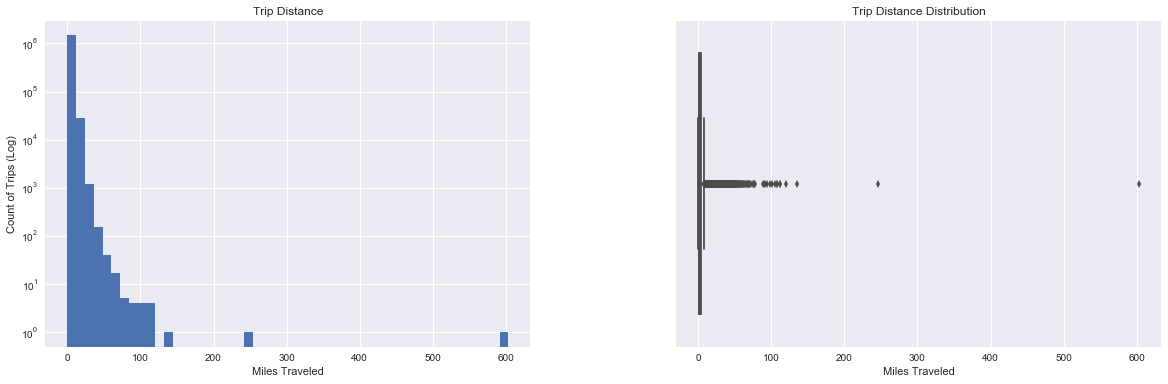

In [11]:
figure, ax = plt.subplots(1,2, figsize = (20, 6))

df_sept_2015.hist('trip_distance', bins = 50, ax = ax[0])
ax[0].set(xlabel="Miles Traveled", ylabel="Count of Trips (Log)", title = 'Trip Distance', yscale = 'log')

sns.boxplot(df_sept_2015['trip_distance'], ax = ax[1])
ax[1].set(xlabel="Miles Traveled", title = 'Trip Distance Distribution')

plt.show()

Trip distance has a long right tail. Its mean is greater than its median due to outliers on the right side. Values have a lower boundary at 0, which makes sense since distance can't be negative. Based on this histogram I can infer 2 things: 1) Most of the distance traveled is very low and 2) there are a few significant outliers with 100s of miles traveled that I should investigate.

In [11]:
df_sept_2015['trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: trip_distance, dtype: float64

Wow most of the data falls under 3.74 miles, which makes sense given how dense NYC is geographically. Normally I'd use the interquartile range rule (1.5x(Q3-Q1)), but that would still only 3.75 miles so I need to establish a better rule for eliminating outliers to ensure they don't affect the model too much. It also seems that there are some trips with 0 distance, so I need to evaluate those before I can do any kind of log transformation on the distance data. I'll drop any data later during the cleaning process.

For now, let's visualize without any outliers, cutting off any datapoints at 3x the std deviation


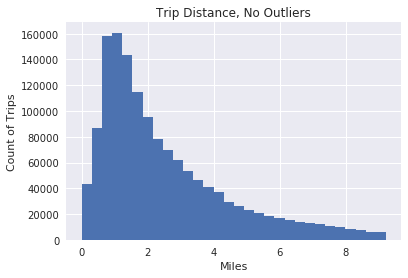

In [12]:
ax = df_sept_2015[df_sept_2015['trip_distance'] < \
                3*df_sept_2015['trip_distance'].std()].hist('trip_distance', bins = 30)

plt.xlabel('Miles')
plt.ylabel('Count of Trips')
plt.title('Trip Distance, No Outliers')


This looks like a lognormal distribution, so I'll definitely want to log transform it once I get rid of the 0 values.

## Trip Distance By Hour & EDA of Airport Trips ## 

In this section I evaluate the general hourly activity and airport specific activity since these might be good features to engineer. Overall I can confirm that the distribution of distance is consistently right skewed as the means are always greater than the medians. Travel distance peaks between 5-6, possibly because of morning commutes to the airports, which are further away from the city. 

Rather than use ratecodeid for airport identification and slicing, I created bounding boxes around the airport coordinates and identified activity through the pickup/dropoff coordinates. This increases the count of airport trips to almost 34k with an average fare of $34.33 (median 31.84) and an average travel time of 28 Mins. 

We roughly see that tip rates and total costs are consistently greater than higher for airport trips than non-airport on an hourly basis, which means that airport data may be a good feature to use for predicting tip percent later on. 

Originally I tried to do reverse geocoding via geopy, but it was impossible given the rate limits of the API (code is preserved here for posterity). 

Lastly, I noticed some inconsistencies with the airport data where seemingly impossible trips (0 distance trips lasting less than a minute) were generating a lot of revenue, which I tried to evaluate later in the anomaly detection portion. 


In [16]:
df_sept_2015.groupby(df_sept_2015['lpep_pickup_datetime'].dt.hour)['trip_distance'].agg(['mean', 'median'])

,mean,median
lpep_pickup_datetime,,
0,3.115276,2.20
1,3.017347,2.12
2,3.046176,2.14
3,3.212945,2.20
4,3.526555,2.36
5,4.133474,2.90
6,4.055149,2.84
7,3.284394,2.17
8,3.048450,1.98


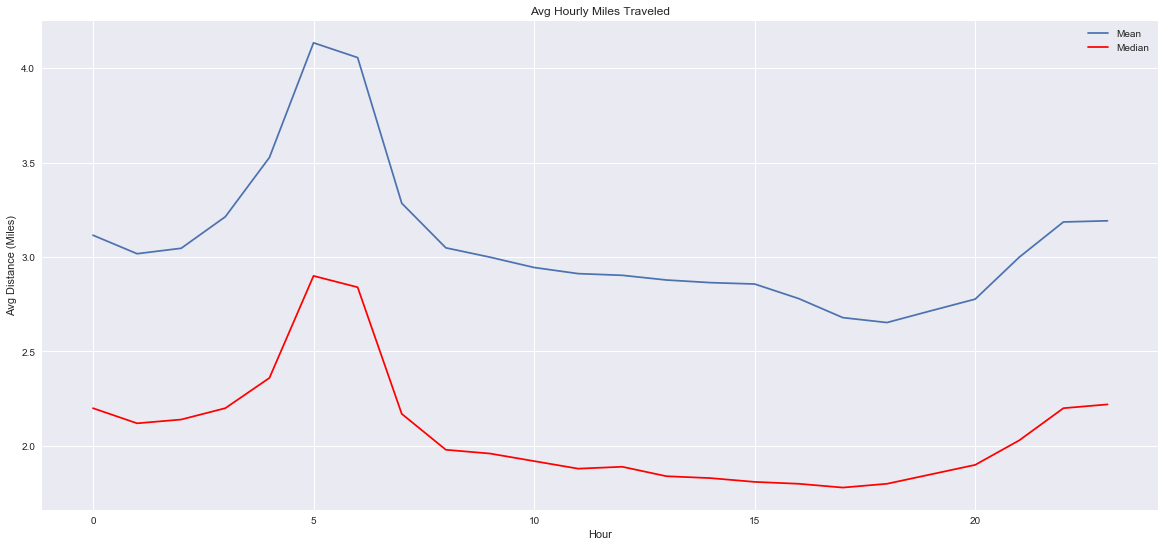

In [14]:
plt.figure(figsize =( 20, 9))                      
plt.plot(df_sept_2015.groupby(df_sept_2015['lpep_pickup_datetime'].dt.hour)['trip_distance'].mean(), 
         label = 'Mean')
plt.plot(df_sept_2015.groupby(df_sept_2015['lpep_pickup_datetime'].dt.hour)['trip_distance'].median(), 
         label = 'Median', color = 'r')
plt.xlabel('Hour') 
plt.ylabel('Avg Distance (Miles)') 
plt.title('Avg Hourly Miles Traveled')
plt.legend()
plt.show()

We see a big jump in average distance traveled (both mean and median) from 4-6 AM. This is probably due to business travelers going to the airport to catch an early morning flight. 

The increase in cab distances at night, starting from 8PM might be due to post work commutes or traveling back from nights out. 

To analyze trips to and fro NYC airports (EWR, LGA, JFK) I could use ratecodeid. However, the ratecodes are missing LGA as a class. Instead I'm going to try to geolocate the starts and ends using geopy, a library that uses Google Maps, Bing, etc. 

First to benchmark - there are 5552 trips coded as to JFK or EWR. 

In [134]:
df_sept_2015[(df_sept_2015['ratecodeid'] == 2) | (df_sept_2015['ratecodeid'] == 3)].shape

(5552, 21)

In [17]:
import geopy
import reverse_geocoder

In [16]:
geolocator = Nominatim()

Let's test out the geolocator on a sample coordinate

In [17]:
geolocator.reverse((df_sept_2015.iloc[0]['pickup_latitude'], df_sept_2015.iloc[0]['pickup_longitude'])).address

'543, Atlantic Avenue, Boerum Hill, BK, Kings County, NYC, New York, 11217, United States of America'

That works (and seems very scary from a privacy point of view). Let's test it now on a trip to or from JFK (ratecodeid ==2)

In [18]:
df_sept_2015[df_sept_2015['ratecodeid'] == 2].index

Int64Index([     31,     146,     902,     961,    1374,    1459,    1684,
               2251,    3294,    3584,
            ...
            1490663, 1492269, 1492819, 1493212, 1493272, 1493532, 1493958,
            1494022, 1494420, 1494605],
           dtype='int64', length=4435)

In [19]:
geolocator.reverse((df_sept_2015['pickup_latitude'][31], df_sept_2015['pickup_longitude'][31])).address

'Roosevelt Avenue, Corona, Queens, Queens County, NYC, New York, 11368, United States of America'

In [20]:
geolocator.reverse((df_sept_2015['dropoff_latitude'][31], df_sept_2015['dropoff_longitude'][31])).address

'Roosevelt Avenue, Corona, Queens, Queens County, NYC, New York, 11368, United States of America'

The start and end destinations seem to be the same. Let's inspect further

In [21]:
df_sept_2015.iloc[31]

vendorid                                   2
lpep_pickup_datetime     2015-09-01 00:07:12
lpep_dropoff_datetime    2015-09-01 00:07:27
store_and_fwd_flag                         N
ratecodeid                                 2
                                ...         
tolls_amount                               0
improvement_surcharge                    0.3
total_amount                            52.8
payment_type                               2
trip_type                                  1
Name: 31, Length: 20, dtype: object

What's going on? This is a 15 second trip that cost 52 dollars and seemingly went barely anywhere. As a New Yorker, I know that it's a flat fee of $52 to/from Manhattan & JFK so there might be a couple of things that happened:

1) The timer and the coordinates are broken and a full trip did occur.  
2) A full trip did not occur/canceled by the customer, but the customer was still charged the JFK fee.   
3) Someone is money laundering and using airport trips as a way to funnel dollars. Since the customer paid cash, this could actually be a possibility.

Let's do a spot check for another JFK trip.

In [22]:
print('start: ', geolocator.reverse((df_sept_2015['pickup_latitude'][146], df_sept_2015['pickup_longitude'][146])).address)
print('end: ', geolocator.reverse((df_sept_2015['dropoff_latitude'][146], df_sept_2015['dropoff_longitude'][146])).address)

start:  49, Utica Avenue, Bed-Stuy, BK, Kings County, NYC, New York, 11233, United States of America
end:  49, Utica Avenue, Bed-Stuy, BK, Kings County, NYC, New York, 11233, United States of America


In [23]:
df_sept_2015.iloc[146]

vendorid                                   2
lpep_pickup_datetime     2015-09-01 00:21:08
lpep_dropoff_datetime    2015-09-01 00:21:12
store_and_fwd_flag                         N
ratecodeid                                 2
                                ...         
tolls_amount                               0
improvement_surcharge                    0.3
total_amount                            52.8
payment_type                               2
trip_type                                  1
Name: 146, Length: 20, dtype: object

Here's another case where trips are lasting only a couple of seconds and the taxi seemingly goes nowhere but the customer paid in full in cash. This is a big anomaly that I'll explore further, looking at the following parameters:

Length of trip < 1 min  
trip_distance ~ 0 since I'll need to clean this data later  
ratecodeid == 2 and/or fare_amount == 52  
payment_type == 2 or 5 (unknown type)  

Let's create a new column for trip length, which we'll convert to minutes

In [43]:
df_sept_2015['trip_length'] = (df_sept_2015['lpep_dropoff_datetime']-\
                               df_sept_2015['lpep_pickup_datetime']).apply(lambda x: x.total_seconds()/60)

In [26]:
df_sept_2015[df_sept_2015['trip_distance'] == 0]

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,0.0,9.75,1,2.0,0.066667
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,0.0,45.00,1,2.0,0.066667
28,2,2015-09-01 00:06:37,2015-09-01 00:09:37,N,1,-73.948479,40.813862,-73.941071,40.818840,1,...,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2,1.0,3.000000
31,2,2015-09-01 00:07:12,2015-09-01 00:07:27,N,2,-73.844269,40.755165,-73.844650,40.755058,1,...,52.0,0.0,0.5,0.00,0.0,0.3,52.80,2,1.0,0.250000
44,2,2015-09-01 00:12:26,2015-09-01 00:12:34,N,5,-73.873322,40.840176,-73.873306,40.840187,1,...,9.0,0.0,0.0,0.00,0.0,0.0,9.00,1,2.0,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494110,2,2015-09-30 23:51:49,2015-09-30 23:51:52,N,5,-73.922417,40.809685,-73.922417,40.809662,1,...,15.0,0.0,0.0,0.00,0.0,0.0,15.00,1,2.0,0.050000
1494250,2,2015-09-30 23:35:26,2015-09-30 23:36:04,N,1,-73.982536,40.693630,-73.982491,40.693581,1,...,2.5,0.5,0.5,5.50,0.0,0.3,9.30,1,1.0,0.633333
1494367,2,2015-09-30 23:24:41,2015-09-30 23:25:50,N,1,-73.891434,40.746582,-73.891418,40.746582,1,...,3.0,0.5,0.5,0.00,0.0,0.3,4.30,2,1.0,1.150000
1494416,2,2015-09-30 23:12:37,2015-09-30 23:12:45,N,5,-73.879875,40.769646,-73.879868,40.769642,1,...,11.0,0.0,0.0,2.20,0.0,0.0,13.20,1,2.0,0.133333


In [27]:
df_sept_2015[df_sept_2015['trip_distance'] == 0].describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.0,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20592.000000,20588.000000,20592.000000
mean,1.784528,2.529380,-70.398541,38.813923,-69.991660,38.591885,1.285256,0.0,13.457103,0.174182,0.282294,1.492805,0.044249,0.172917,15.623263,1.661956,1.343890,12.862307
std,0.411159,2.506194,15.745924,8.681617,16.579787,9.141899,0.897019,0.0,27.349150,0.351146,0.269995,7.020632,1.048510,0.161993,28.860032,0.658469,0.475016,111.660534
min,1.000000,1.000000,-83.277878,0.000000,-83.277832,0.000000,0.000000,0.0,-475.000000,-1.000000,-0.500000,-5.000000,-15.290000,-0.300000,-475.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,-73.948885,40.685566,-73.947281,40.685626,1.000000,0.0,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,3.800000,1.000000,1.000000,0.066667
50%,2.000000,1.000000,-73.933296,40.751637,-73.930550,40.753578,1.000000,0.0,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.000000,2.000000,1.000000,0.266667
75%,2.000000,5.000000,-73.890785,40.813540,-73.886419,40.815085,1.000000,0.0,15.000000,0.500000,0.500000,0.000000,0.000000,0.300000,16.800000,2.000000,2.000000,1.566667
max,2.000000,99.000000,0.000000,42.460007,0.000000,42.460091,9.000000,0.0,500.000000,12.000000,0.500000,300.000000,77.000000,0.300000,500.000000,5.000000,2.000000,1439.400000


We can assume that some of these trips look real. You can see that some of the trip lengths are a couple of minutes so they could be the result of a broken gps. You also see some 0 lat/longitude coordinates, which is an indicator for a broken GPS.  

Let's evaluate any fares with 0 distance, less than 1 minute durations, and who paid in cash.

In [28]:
df_anomaly = df_sept_2015[(df_sept_2015['trip_distance'] == 0) & 
             (df_sept_2015['payment_type'] == 2) & (df_sept_2015['trip_length'] < 1)].reset_index()

In [29]:
df_anomaly.describe()

,index,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,6.589000e+03,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.0,6589.000000,6589.000000,6589.000000,6589.0,6589.000000,6589.000000,6589.000000,6589.0,6589.000000,6589.000000
mean,7.372920e+05,1.703445,1.966915,-71.185528,39.244727,-64.228219,35.412305,1.344514,0.0,12.430071,0.218774,0.381469,0.0,0.038053,0.231978,13.299449,2.0,1.173774,0.234520
std,4.337288e+05,0.456773,2.302120,13.961349,7.696943,24.953719,13.758261,0.966182,0.0,20.897285,0.344147,0.217421,0.0,0.687959,0.128529,20.801255,0.0,0.378944,0.242564
min,3.100000e+01,1.000000,1.000000,-83.277878,0.000000,-83.277832,0.000000,0.000000,0.0,-52.000000,-1.000000,-0.500000,0.0,0.000000,-0.300000,-52.800000,2.0,1.000000,0.000000
25%,3.579250e+05,1.000000,1.000000,-73.950546,40.687607,-73.946281,40.677174,1.000000,0.0,2.500000,0.000000,0.500000,0.0,0.000000,0.300000,3.300000,2.0,1.000000,0.050000
50%,7.380670e+05,2.000000,1.000000,-73.936653,40.751583,-73.927277,40.747673,1.000000,0.0,2.500000,0.000000,0.500000,0.0,0.000000,0.300000,3.800000,2.0,1.000000,0.150000
75%,1.110045e+06,2.000000,2.000000,-73.896950,40.808617,-73.870079,40.805706,1.000000,0.0,12.000000,0.500000,0.500000,0.0,0.000000,0.300000,12.000000,2.0,1.000000,0.350000
max,1.491583e+06,2.000000,99.000000,0.000000,42.460007,0.000000,42.460091,9.000000,0.0,417.000000,1.000000,0.500000,0.0,20.000000,0.300000,417.000000,2.0,2.000000,0.983333


In [30]:
df_anomaly['total_amount'].sum()

87630.07000000858

In [83]:
df_anomaly[df_anomaly['ratecodeid'] == 2].describe()

,index,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,7.550000e+02,755.000000,755.0,755.000000,755.000000,755.000000,755.000000,755.000000,755.0,755.000000,755.0,755.000000,755.0,755.000000,755.000000,755.000000,755.0,755.0,755.000000
mean,7.089919e+05,1.952318,2.0,-72.556374,39.988822,-72.556439,39.988917,1.397351,0.0,50.966887,0.0,0.493377,0.0,0.028530,0.295232,51.778728,2.0,1.0,0.199558
std,4.361759e+05,0.213234,0.0,9.979825,5.500555,9.979835,5.500566,0.991204,0.0,8.616357,0.0,0.072534,0.0,0.615965,0.046106,8.773910,0.0,0.0,0.183491
min,3.100000e+01,1.000000,2.0,-74.016899,0.000000,-74.016899,0.000000,1.000000,0.0,-52.000000,0.0,-0.500000,0.0,0.000000,-0.300000,-52.800000,2.0,1.0,0.000000
25%,3.157350e+05,2.000000,2.0,-73.955780,40.690485,-73.956066,40.690670,1.000000,0.0,52.000000,0.0,0.500000,0.0,0.000000,0.300000,52.800000,2.0,1.0,0.083333
50%,6.915970e+05,2.000000,2.0,-73.940186,40.743069,-73.940651,40.743011,1.000000,0.0,52.000000,0.0,0.500000,0.0,0.000000,0.300000,52.800000,2.0,1.0,0.133333
75%,1.090038e+06,2.000000,2.0,-73.898750,40.797853,-73.896759,40.797115,1.000000,0.0,52.000000,0.0,0.500000,0.0,0.000000,0.300000,52.800000,2.0,1.0,0.250000
max,1.482790e+06,2.000000,2.0,0.000000,40.880707,0.000000,40.880600,6.000000,0.0,52.000000,0.0,0.500000,0.0,16.000000,0.300000,68.800000,2.0,1.0,0.983333


In [84]:
df_anomaly[df_anomaly['ratecodeid'] == 2]['total_amount'].sum()

39092.940000000024

6600 of the 1.5 mil trips in Sept 2015 (.44%) were virtually impossible trips yet accounting for over $87k in reported revenue in a single month. 

Of these 6.6k trips, 755 (11 percent) of them were trips to JFK which have a flat fare of $52 and account for 40k.  Could they just be reporting errors? Maybe. I'll explore this further at the bottom of the notebook. For now let's table the data and move forward.

Back to airport data - let's add in the start and end addresses as parameters. I created a function, make_address, above to help with this. 

In [121]:
make_address(df_sept_2015, 'pickup_latitude', 'pickup_longitude', 'pickup_address')

GeocoderServiceError: HTTP Error 429: Too Many Requests

Big hiccup - I can't pull this many requests from geopy since all the APIs it uses have rate limits. At best I can only pull an address once per minute, which at ~3 million coordinates would take about 34 days. I also can't use distributed servers or multiple threads per their policies, so there are few ways to get around this without paying for enterprise services. 

However, I don't fully need addresses (it's a little bit of overkill) to evaluate airport data. I can instead just create bounding boxes around airport coordinates and filter out for any pickups/dropoffs that fall within the area. Also I only need to do that for LaGuardia since I have JFK/Newark trips in ratecodeID.

Base off of Google Maps, the upper coordinates for LaGuardia are (40.779467, -73.884853) and lower coordinates are (40.766564, -73.862022)

In [20]:
lga_upper = (40.779467, -73.884853)
lga_lower = (40.766564, -73.862022)

In [44]:
df_lga = find_airport(df_sept_2015, 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', lga_upper, lga_lower)

In [45]:
df_lga.describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000,21577.000000
mean,1.799370,1.139871,-73.841046,40.712729,-73.857271,40.763925,1.386013,5.910520,19.907638,0.264471,0.482922,2.802300,1.014516,0.289948,24.761992,1.377115,1.032396,21.604182
std,0.400481,0.731143,2.359508,1.301362,1.005908,0.555329,1.063952,3.735935,10.611023,0.390969,0.091833,3.284262,2.174781,0.054603,13.403229,0.495737,0.177052,77.054242
min,1.000000,1.000000,-74.034607,0.000000,-76.121590,0.000000,0.000000,0.000000,-45.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-45.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,-73.951202,40.741390,-73.872818,40.770332,1.000000,3.160000,11.500000,0.000000,0.500000,0.000000,0.000000,0.300000,13.800000,1.000000,1.000000,9.383333
50%,2.000000,1.000000,-73.917816,40.754341,-73.871086,40.773617,1.000000,5.000000,17.500000,0.000000,0.500000,2.160000,0.000000,0.300000,20.380000,1.000000,1.000000,14.066667
75%,2.000000,1.000000,-73.890610,40.770107,-73.865669,40.774208,1.000000,8.110000,26.500000,0.500000,0.500000,5.000000,0.000000,0.300000,34.800000,2.000000,1.000000,21.833333
max,2.000000,5.000000,0.000000,40.963539,0.000000,42.799343,6.000000,246.280000,300.000000,1.000000,0.500000,77.440000,25.040000,0.300000,387.190000,4.000000,2.000000,1438.100000


In [46]:
df_lga.head(15)

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
26,2,2015-09-01 00:00:35,2015-09-01 00:08:31,N,1,-73.844879,40.755024,-73.872223,40.773991,1,...,10.5,0.5,0.5,2.36,0.00,0.3,14.16,1,1.0,7.933333
209,2,2015-09-01 00:06:14,2015-09-01 00:13:14,N,1,-73.844925,40.754948,-73.866318,40.767796,1,...,10.5,0.5,0.5,0.00,0.00,0.3,11.80,2,1.0,7.000000
613,2,2015-09-01 00:44:56,2015-09-01 00:52:31,N,1,-73.825836,40.764244,-73.866325,40.771423,6,...,11.0,0.5,0.5,0.00,0.00,0.3,12.30,2,1.0,7.583333
653,2,2015-09-01 00:34:12,2015-09-01 00:40:14,N,1,-73.845688,40.754768,-73.866310,40.767639,1,...,10.5,0.5,0.5,0.00,0.00,0.3,11.80,2,1.0,6.033333
2057,1,2015-09-01 01:29:44,2015-09-01 01:41:00,N,1,-73.939285,40.805317,-73.871529,40.774284,1,...,19.0,0.5,0.5,8.00,0.00,0.3,28.30,1,1.0,11.266667
2486,2,2015-09-01 02:56:59,2015-09-01 03:10:58,N,5,-73.942459,40.812317,-73.871841,40.772121,1,...,38.0,0.0,0.0,0.00,0.00,0.0,38.00,2,2.0,13.983333
2623,1,2015-09-01 02:31:19,2015-09-01 02:37:11,N,1,-73.869484,40.749355,-73.871216,40.774323,1,...,8.0,0.5,0.5,0.00,0.00,0.3,9.30,2,1.0,5.866667
2849,2,2015-09-01 03:55:19,2015-09-01 04:04:23,N,1,-73.937286,40.804234,-73.870544,40.773849,1,...,17.5,0.5,0.5,2.66,5.54,0.3,27.00,1,1.0,9.066667
2892,2,2015-09-01 03:52:10,2015-09-01 04:14:25,N,1,-73.942657,40.685631,-73.871895,40.774380,1,...,28.5,0.5,0.5,5.96,0.00,0.3,35.76,1,1.0,22.250000
2931,2,2015-09-01 03:54:10,2015-09-01 04:10:40,N,1,-73.936852,40.844681,-73.872833,40.774128,1,...,26.5,0.5,0.5,0.00,0.00,0.3,27.80,2,1.0,16.500000


Great - it looks like 21k trips in Sept were to or from LGA, which sounds realistic. However, according to http://laguardiaairport.com/about-us/facts-and-statistics/ in 2015 LGA had 28.4MM passengers, or avg 2.37MM passengers per month. The 21k trips would account for .88% of the LGA travelers. 

Interestingly it seems like some of them are coded as JFK trips, which also make sense since there's no specific ID for LGA. Let's make sure that I didn't screw anything up and I'm not pulling in all trips coded as JFK.

In [47]:
df_sept_2015[df_sept_2015['ratecodeid'] == 2].shape

(4435, 21)

In [48]:
df_lga[df_lga['ratecodeid'] == 2].shape

(22, 21)

Everything looks good. To make the analysis easier, I'm just going to pull all the airport data into a new dataframe. This way we can perform any specific operations on the airport data and also preserve it for posterity. First I'll change the ratecodeid for LGA to 7 so I can later classify the airport data.

In [49]:
df_lga['ratecodeid'] = 7

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [50]:
df_airport = df_lga

In [51]:
df_airport.append(df_sept_2015[(df_sept_2015['ratecodeid'] == 2) | \
                                       (df_sept_2015['ratecodeid'] == 3)], ignore_index = True)


,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
0,2,2015-09-01 00:00:35,2015-09-01 00:08:31,N,7,-73.844879,40.755024,-73.872223,40.773991,1,...,10.5,0.5,0.5,2.36,0.00,0.3,14.16,1,1.0,7.933333
1,2,2015-09-01 00:06:14,2015-09-01 00:13:14,N,7,-73.844925,40.754948,-73.866318,40.767796,1,...,10.5,0.5,0.5,0.00,0.00,0.3,11.80,2,1.0,7.000000
2,2,2015-09-01 00:44:56,2015-09-01 00:52:31,N,7,-73.825836,40.764244,-73.866325,40.771423,6,...,11.0,0.5,0.5,0.00,0.00,0.3,12.30,2,1.0,7.583333
3,2,2015-09-01 00:34:12,2015-09-01 00:40:14,N,7,-73.845688,40.754768,-73.866310,40.767639,1,...,10.5,0.5,0.5,0.00,0.00,0.3,11.80,2,1.0,6.033333
4,1,2015-09-01 01:29:44,2015-09-01 01:41:00,N,7,-73.939285,40.805317,-73.871529,40.774284,1,...,19.0,0.5,0.5,8.00,0.00,0.3,28.30,1,1.0,11.266667
5,2,2015-09-01 02:56:59,2015-09-01 03:10:58,N,7,-73.942459,40.812317,-73.871841,40.772121,1,...,38.0,0.0,0.0,0.00,0.00,0.0,38.00,2,2.0,13.983333
6,1,2015-09-01 02:31:19,2015-09-01 02:37:11,N,7,-73.869484,40.749355,-73.871216,40.774323,1,...,8.0,0.5,0.5,0.00,0.00,0.3,9.30,2,1.0,5.866667
7,2,2015-09-01 03:55:19,2015-09-01 04:04:23,N,7,-73.937286,40.804234,-73.870544,40.773849,1,...,17.5,0.5,0.5,2.66,5.54,0.3,27.00,1,1.0,9.066667
8,2,2015-09-01 03:52:10,2015-09-01 04:14:25,N,7,-73.942657,40.685631,-73.871895,40.774380,1,...,28.5,0.5,0.5,5.96,0.00,0.3,35.76,1,1.0,22.250000
9,2,2015-09-01 03:54:10,2015-09-01 04:10:40,N,7,-73.936852,40.844681,-73.872833,40.774128,1,...,26.5,0.5,0.5,0.00,0.00,0.3,27.80,2,1.0,16.500000


Adding on Newark and JFK data increased it only 5k, which is a little suspect. However, I think this might hold because:

1) We're evaluating only green cab data, which means the pickups occur only in the outer boroughs. Outer boroughs may favor LGA over Newark because of proximity.  
2) JFK has the airtrain and subways that go to JFK. Newark has the NJTransit. LGA doesn't have any public transportation direct, so taxi would be the easiest and favored way to get there. 

Just to check, I'll pull the coordinates to the other airports and evaluate.

In [52]:
jfk_upper = (40.660473, -73.811759)
jfk_lower = (40.643477, -73.775110)
ewr_upper = (40.708438, -74.184169)
ewr_lower = (40.672211, -74.175061)


In [53]:
df_jfk = find_airport(df_sept_2015, 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', jfk_upper, jfk_lower)
df_jfk.describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000
mean,1.796665,1.450534,-73.777308,40.650601,-73.765777,40.636086,1.379393,13.646712,41.155189,0.195810,0.466139,5.150556,0.989557,0.279914,48.237165,1.340402,1.066097,39.767527
std,0.402497,1.034431,3.275687,1.805368,1.181726,0.651018,1.041208,4.992514,13.938139,0.354199,0.125809,5.235518,2.147438,0.075087,17.145415,0.482272,0.248462,85.193761
min,1.000000,1.000000,-74.220581,0.000000,-74.255402,0.000000,0.000000,0.000000,-4.500000,-0.500000,-0.500000,0.000000,0.000000,-0.300000,-5.800000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,-73.960884,40.688620,-73.789726,40.643997,1.000000,10.900000,34.000000,0.000000,0.500000,0.000000,0.000000,0.300000,37.800000,1.000000,1.000000,23.975000
50%,2.000000,1.000000,-73.944664,40.718925,-73.783012,40.645382,1.000000,14.010000,42.000000,0.000000,0.500000,5.000000,0.000000,0.300000,49.550000,1.000000,1.000000,33.250000
75%,2.000000,1.000000,-73.887089,40.763931,-73.780926,40.646881,1.000000,17.530000,52.000000,0.500000,0.500000,9.160000,0.000000,0.300000,58.560000,2.000000,1.000000,43.166667
max,2.000000,5.000000,0.000000,40.963268,0.000000,40.963268,8.000000,48.750000,450.000000,1.000000,0.500000,63.000000,20.830000,0.300000,450.000000,4.000000,2.000000,1438.383333


In [54]:
df_newark = find_airport(df_sept_2015, 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', ewr_upper, ewr_lower)
df_newark.describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,1.765805,2.811782,-73.864366,40.685577,-74.178073,40.692373,1.386494,20.346853,75.786063,0.188218,0.135057,11.582026,9.563132,0.261207,97.515704,1.281609,1.126437,54.369684
std,0.423799,1.211660,2.804534,1.545619,0.010109,0.007505,1.047802,7.155564,20.650157,0.351448,0.223782,12.024521,6.939632,0.102013,24.699106,0.489905,0.332580,103.746145
min,1.000000,1.000000,-74.188393,0.000000,-74.184113,40.615849,0.000000,0.000000,-2.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-3.300000,1.000000,1.000000,0.033333
25%,2.000000,3.000000,-73.986456,40.691680,-74.179279,40.689976,1.000000,16.297500,65.000000,0.000000,0.000000,0.000000,9.562500,0.300000,85.000000,1.000000,1.000000,35.216667
50%,2.000000,3.000000,-73.959457,40.718193,-74.177544,40.692114,1.000000,20.610000,77.500000,0.000000,0.000000,11.620000,9.750000,0.300000,96.550000,1.000000,1.000000,43.025000
75%,2.000000,3.000000,-73.946014,40.806372,-74.177200,40.695057,1.000000,25.500000,86.500000,0.000000,0.500000,18.697500,11.750000,0.300000,111.775000,2.000000,1.000000,56.295833
max,2.000000,5.000000,0.000000,41.009159,-73.966965,40.854305,9.000000,57.470000,165.000000,1.000000,0.500000,100.000000,50.000000,0.300000,200.040000,4.000000,2.000000,1410.083333


JFK looks reasonable - the avg trip is 13.66 miles and costs $48. However, here are far fewer Newark trips based off coordinates than coded for Newark despite the data looking reasonable (high travel distance, fares, and trip lengths). Let's evaluate the data that's not in df_newark 

In [55]:
df_not_newark = df_sept_2015[df_sept_2015['ratecodeid'] \
                                     == 3][~df_sept_2015[df_sept_2015['ratecodeid'] \
                                                                 == 3].index.isin(df_newark.index)]

In [56]:
df_not_newark.describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,701.000000,701.0,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.0,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,1.580599,3.0,-73.608013,40.580855,-72.992014,40.234717,1.402282,4.728688,31.027817,0.312411,0.0,2.180342,1.818174,0.277746,35.616491,2.068474,1.002853,14.471350
std,0.493813,0.0,4.831776,2.664630,8.332094,4.593137,1.036861,9.101046,25.565021,0.405466,0.0,7.715363,4.556036,0.111181,32.301875,0.798850,0.053376,57.659634
min,1.000000,3.0,-74.089363,0.000000,-74.445961,0.000000,0.000000,0.000000,-27.000000,-1.000000,0.0,0.000000,0.000000,-0.300000,-27.800000,1.000000,1.000000,0.000000
25%,1.000000,3.0,-73.956879,40.685654,-73.972755,40.690338,1.000000,0.000000,20.000000,0.000000,0.0,0.000000,0.000000,0.300000,20.300000,2.000000,1.000000,0.150000
50%,2.000000,3.0,-73.941048,40.751534,-73.945374,40.751640,1.000000,0.150000,20.000000,0.000000,0.0,0.000000,0.000000,0.300000,21.300000,2.000000,1.000000,0.466667
75%,2.000000,3.0,-73.916618,40.808979,-73.912361,40.809341,1.000000,6.430000,36.500000,0.500000,0.0,0.000000,0.000000,0.300000,43.300000,2.000000,1.000000,17.966667
max,2.000000,3.0,0.000000,42.358013,0.000000,42.358238,6.000000,112.600000,182.500000,1.000000,0.0,130.000000,44.580000,0.300000,203.300000,5.000000,2.000000,1408.100000


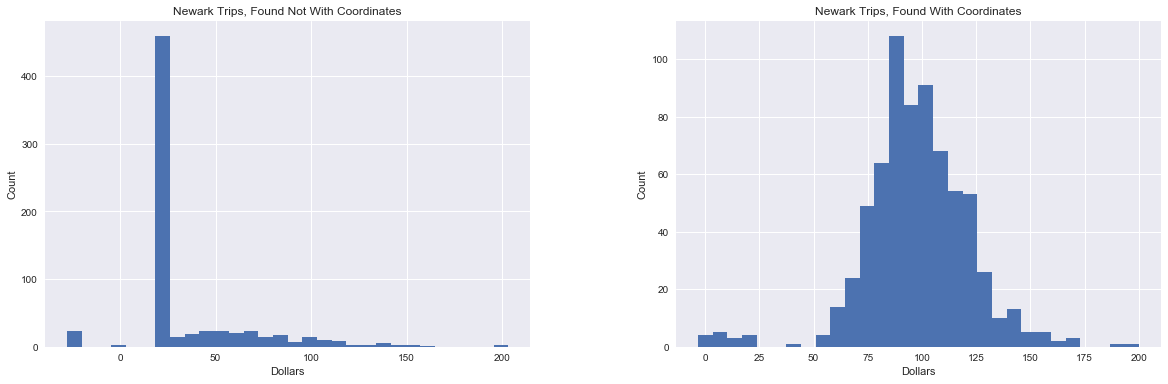

In [57]:
figure, ax = plt.subplots(1,2, figsize = (20,6))

df_not_newark.hist('total_amount', bins = 30, ax = ax[0])
ax[0].set(xlabel = 'Dollars', ylabel = 'Count', title = 'Newark Trips, Found Not With Coordinates')

df_newark.hist('total_amount', bins = 30, ax = ax[1])
ax[1].set(xlabel = 'Dollars', ylabel = 'Count', title = 'Newark Trips, Found With Coordinates')
plt.show()

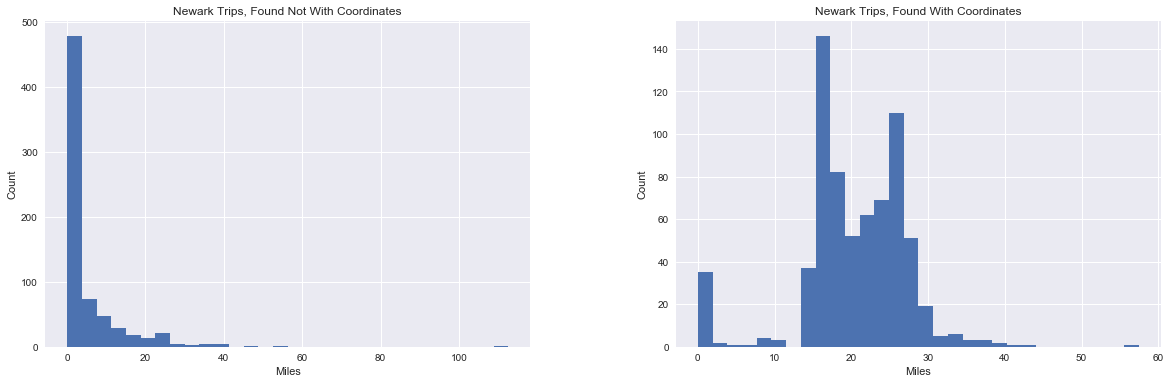

In [58]:
figure, ax = plt.subplots(1,2, figsize = (20,6))

df_not_newark.hist('trip_distance', bins = 30, ax = ax[0])
ax[0].set(xlabel = 'Miles', ylabel = 'Count', title = 'Newark Trips, Found Not With Coordinates')

df_newark.hist('trip_distance', bins = 30, ax = ax[1])
ax[1].set(xlabel = 'Miles', ylabel = 'Count', title = 'Newark Trips, Found With Coordinates')
plt.show()

It looks like most of the trips that I couldn't find via Newark coordinates have low distance and fare costs, too little to be realistic for green cabs to use. I can try to match the not_newark coordinates to regions and confirm they're not going to or from NJ, but for simplicity sake I'm just going to stick with coordinates since they look more reasonable (the costs and distance look normally distributed vs clustering around 0). Let's revise df_airport with the dataframes made from the airport coordinates.

In [59]:
df_jfk['ratecodeid'] = 2
df_newark['ratecodeid'] = 3

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
df_airport = df_lga

In [61]:
df_airport = df_airport.append(df_jfk)
df_airport = df_airport.append(df_newark)

In [62]:
df_airport.describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000,33968.000000
mean,1.797751,5.196567,-73.819579,40.690782,-73.832343,40.718445,1.383744,8.869848,28.367998,0.239269,0.470016,3.790687,1.181083,0.285904,34.335082,1.362518,1.045926,28.529085
std,0.401683,2.383905,2.718890,1.499201,1.062016,0.587765,1.055820,5.883293,17.174609,0.379370,0.119334,4.663470,2.654655,0.063899,20.841106,0.491454,0.209327,81.105104
min,1.000000,2.000000,-74.220581,0.000000,-76.121590,0.000000,0.000000,0.000000,-45.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-45.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,-73.955530,40.707647,-73.872345,40.646835,1.000000,3.670000,13.500000,0.000000,0.500000,0.000000,0.000000,0.300000,16.300000,1.000000,1.000000,11.166667
50%,2.000000,7.000000,-73.928539,40.747063,-73.865662,40.770161,1.000000,7.710000,25.000000,0.000000,0.500000,2.560000,0.000000,0.300000,31.840000,1.000000,1.000000,19.550000
75%,2.000000,7.000000,-73.890678,40.770042,-73.789030,40.774017,1.000000,12.510000,39.500000,0.500000,0.500000,6.460000,0.000000,0.300000,46.550000,2.000000,1.000000,32.733333
max,2.000000,7.000000,0.000000,41.009159,0.000000,42.799343,9.000000,246.280000,450.000000,1.000000,0.500000,100.000000,50.000000,0.300000,450.000000,4.000000,2.000000,1438.383333


From a top line:

We see 33.9k trips to or from airports in Sept 2015, with an average fare of 34.33 (median 31.84). The average time it takes for the trip is 28 Mins and users travel around 8.872 miles (this is a mere 19 MPH!). Let's break this down by the individual airport and compare the data to nonairport trips.

In [84]:
df_not_airport = df_sept_2015.drop(df_airport.index)

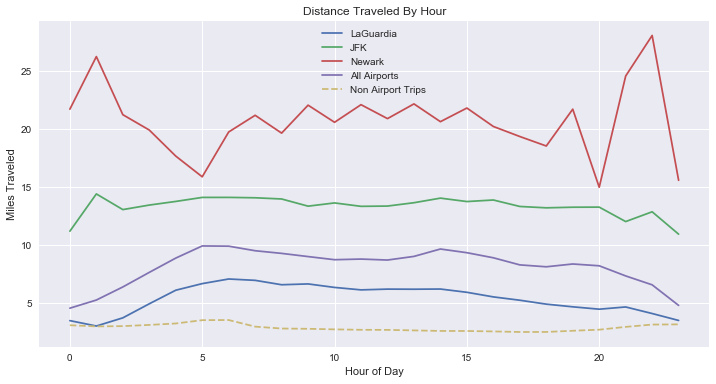

In [92]:
plt.figure(figsize = (12, 6))
           
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 7]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_distance'].mean(), label = 'LaGuardia')
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 2]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_distance'].mean(), label = 'JFK')
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 3]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_distance'].mean(), label = 'Newark')
plt.plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_distance'].mean(), label = 'All Airports')

plt.plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_distance'].mean(), '--', label = 'Non Airport Trips')

plt.xlabel('Hour of Day')
plt.ylabel('Miles Traveled')
plt.title('Distance Traveled By Hour')
plt.legend()

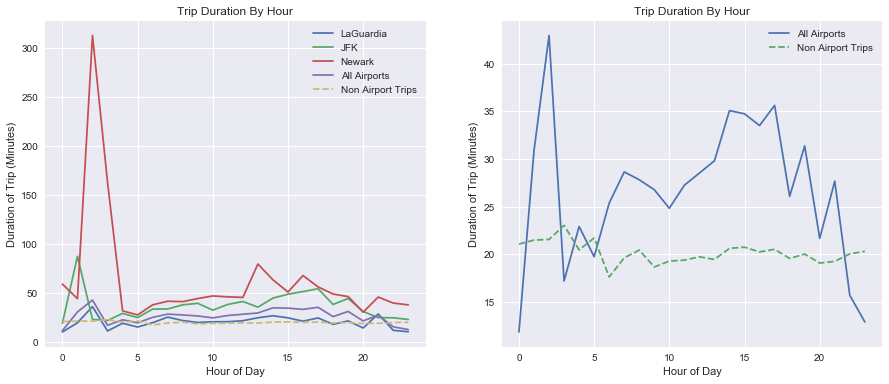

In [107]:
figure, ax = plt.subplots(1,2, figsize = (15, 6))
           
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 7]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), label = 'LaGuardia')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 2]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), label = 'JFK')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 3]['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), label = 'Newark')
ax[0].plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), label = 'All Airports')
ax[0].plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), '--', label = 'Non Airport Trips')
ax[1].plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), label = 'All Airports')
ax[1].plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['trip_length'].mean(), '--', label = 'Non Airport Trips')

ax[0].set(xlabel = 'Hour of Day', ylabel = 'Duration of Trip (Minutes)', title = 'Trip Duration By Hour')
ax[0].legend()

ax[1].set(xlabel = 'Hour of Day', ylabel = 'Duration of Trip (Minutes)', title = 'Trip Duration By Hour')
ax[1].legend()

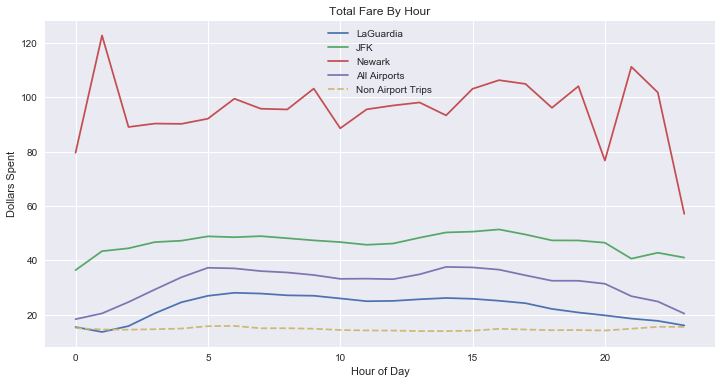

In [206]:
plt.figure(figsize = (12, 6))
           
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 7]['lpep_pickup_datetime']\
                                   .dt.hour)['total_amount'].mean(), label = 'LaGuardia')
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 2]['lpep_pickup_datetime']\
                                   .dt.hour)['total_amount'].mean(), label = 'JFK')
plt.plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 3]['lpep_pickup_datetime']\
                                   .dt.hour)['total_amount'].mean(), label = 'Newark')
plt.plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                                   .dt.hour)['total_amount'].mean(), label = 'All Airports')

plt.plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['total_amount'].mean(), '--', label = 'Non Airport Trips')

plt.xlabel('Hour of Day')
plt.ylabel('Dollars Spent')
plt.title('Total Fare By Hour')
plt.legend()

Newark has some pretty irregular travel distance depending on the hour of the day, which might be due to the significantly lower counts of travel compared to the rest of the data. However, it seems that people are more willing to travel further to Newark at night via cab, which makes sense. The stable hourly distance data for non-airport trips confirms that the overall bump we see from 5-6AM are due to airport trips.  

Trip duration spikes up in the early mornings too. When building a model I should make sure to do some sanity checks on this since a 5 hour taxi trip doesn't make sense, unless people are stopped and dancing on the freeway La La Land-style. If I were travel to/from the airport, I should avoid 2-4PM since they seem to have the highest traffic times.
Ideal times to leave for airport: 3-5AM, 11-12AM.  


The rest of the airports see some lift in total during day times, which accounts for traffic whereas non-airport travel is relatively flat.

One of the things that's constantly crossed my mind as a NYer is whether it makes the most sense for taxi drivers to focus on airport pickups or local pickups. Luckily I can now evaluate that with a basic revenue/time calculation.


In [122]:
df_airport = df_airport.drop(df_airport[df_airport['trip_length'] == 0].index)
df_not_airport = df_not_airport.drop(df_not_airport[df_not_airport['trip_length'] == 0].index)

In [123]:
df_airport['fare/minute'] = df_airport['fare_amount']/df_airport['trip_length']
df_not_airport['fare/minute'] = df_not_airport['fare_amount']/df_not_airport['trip_length']
df_airport['tip/minute'] = df_airport['tip_amount']/df_airport['trip_length']
df_not_airport['tip/minute'] = df_not_airport['tip_amount']/df_not_airport['trip_length']

In [141]:
print("Avg Airport Fare/Minute", df_airport['fare_amount'].sum()/df_airport['trip_length'].sum())
print("Avg Non Airport Fare/Minute", df_not_airport['fare_amount'].sum()/df_not_airport['trip_length'].sum(), "\n")

print("Avg Airport Tip/Minute", df_airport['tip_amount'].sum()/df_airport['trip_length'].sum())
print("Avg Non Airport Tip/Minute", df_not_airport['tip_amount'].sum()/df_not_airport['trip_length'].sum())

Avg Airport Fare/Minute 0.9939951800820304
Avg Non Airport Fare/Minute 0.6060879740938027 

Avg Airport Tip/Minute 0.13284359991179295
Avg Non Airport Tip/Minute 0.058601812106731


In [143]:
print("Avg Airport Fare/Minute T-test: ",ttest_ind(df_airport['fare/minute'], 
          df_not_airport['fare/minute'], equal_var=False))

print("Avg Airport Tip/Minute T-test: ",ttest_ind(df_airport['tip/minute'], 
          df_not_airport['tip/minute'], equal_var=False))

Avg Airport Fare/Minute T-test:  Ttest_indResult(statistic=7.8889132041428427, pvalue=3.138208644187693e-15)
Avg Airport Tip/Minute T-test:  Ttest_indResult(statistic=6.2692558797720652, pvalue=3.6703343822446312e-10)


T-tests show that the difference in these two rates are statistically significant.

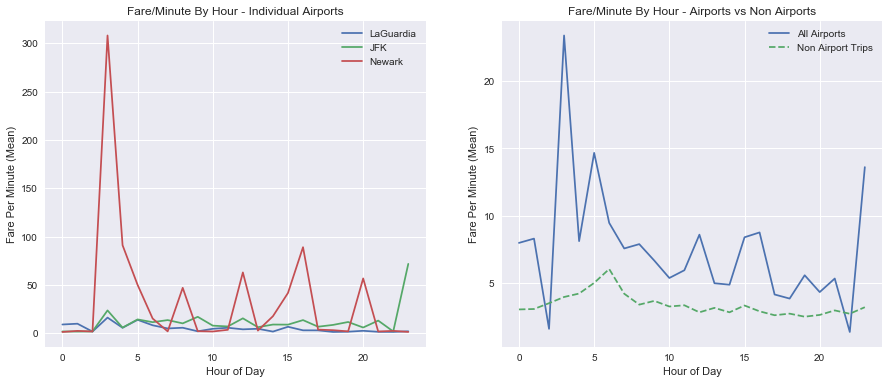

In [132]:
figure, ax = plt.subplots(1,2, figsize = (15, 6))
           
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 7]['lpep_pickup_datetime']\
                                   .dt.hour)['fare/minute'].mean(), label = 'LaGuardia')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 2]['lpep_pickup_datetime']\
                                   .dt.hour)['fare/minute'].mean(), label = 'JFK')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 3]['lpep_pickup_datetime']\
                                   .dt.hour)['fare/minute'].mean(), label = 'Newark')

ax[1].plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                              .dt.hour)['fare/minute'].mean(), label = 'All Airports')
ax[1].plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['fare/minute'].mean(), '--', label = 'Non Airport Trips')

ax[0].set(xlabel = 'Hour of Day', ylabel = 'Fare Per Minute (Mean)', title = 'Fare/Minute By Hour - Individual Airports')
ax[0].legend()

ax[1].set(xlabel = 'Hour of Day', ylabel = 'Fare Per Minute (Mean)', 
          title = 'Fare/Minute By Hour - Airports vs Non Airports')
ax[1].legend()

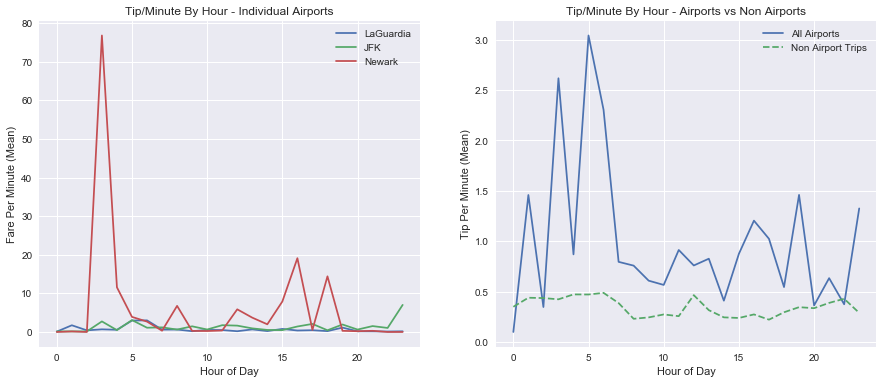

In [135]:
figure, ax = plt.subplots(1,2, figsize = (15, 6))
           
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 7]['lpep_pickup_datetime']\
                                   .dt.hour)['tip/minute'].mean(), label = 'LaGuardia')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 2]['lpep_pickup_datetime']\
                                   .dt.hour)['tip/minute'].mean(), label = 'JFK')
ax[0].plot(df_airport.groupby(df_airport[df_airport['ratecodeid'] == 3]['lpep_pickup_datetime']\
                                   .dt.hour)['tip/minute'].mean(), label = 'Newark')

ax[1].plot(df_airport.groupby(df_airport['lpep_pickup_datetime']\
                              .dt.hour)['tip/minute'].mean(), label = 'All Airports')
ax[1].plot(df_not_airport.groupby(df_not_airport['lpep_pickup_datetime']\
                                   .dt.hour)['tip/minute'].mean(), '--', label = 'Non Airport Trips')

ax[0].set(xlabel = 'Hour of Day', ylabel = 'Fare Per Minute (Mean)', title = 'Tip/Minute By Hour - Individual Airports')
ax[0].legend()

ax[1].set(xlabel = 'Hour of Day', ylabel = 'Tip Per Minute (Mean)', 
          title = 'Tip/Minute By Hour - Airports vs Non Airports')
ax[1].legend()

Cabbies seem to be better off focusing on airport trips, at least from 4am - 9PM. Airport Trips generate more total revenue per minute ($1.12 vs $.66) on average, assuming no difference in downtime. However, if they need to double back without a fare, it makes more sense to stick local


In [58]:
df_sept_2015.to_pickle('df_sept_uncleaned')
df_airport.to_pickle('df_airport')

## LET'S CLEAN SOME (MORE) DATA! ## 

Based off the preliminary analysis above I know for certain that data needs to be cleaned. There are a couple of assumptions I can make:

1) Dollars can never be below 0  (Drop these or change to abs)   
2) 0 Coordinates are wrong  (Drop these)  
3) Fares should be at least $2.5 as that's the base (Change to median since these seem to be technical issues)  
4) Distance should not be 0 (change to .1 or median, maybe just do log transformation (x+.01))  
5) RateCodeIDs should be 1-7  (change to the mode as these are technical issues)  
6) Outliers for trip duration and trip_distance should be changed (within reason) (outliers beyond a threshold change to median or drop)  

I'm going to use the helper functions I created above for the cleaning. I've packaged up this process as 2 functions (clean_data & change_invalid_data) so that I can repeat this work on future cab datasets and below in the anomaly detection section, but below is my exploration of the data that led me to the process. 

In [57]:
df_sept_cleaned = df_sept_2015.copy()

In [58]:
df_sept_cleaned[(df_sept_cleaned['total_amount'] < 0) | (df_sept_cleaned['fare_amount'] < 0)].describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,2417.0,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,2.0,1.412495,-73.496164,40.525932,-73.802077,40.694547,1.405048,0.270194,-10.281940,-0.334919,-0.452420,-0.054791,-0.019665,-0.274928,-11.419193,3.273066,1.081920,10.497711
std,0.0,1.140709,5.611195,3.094524,3.005781,1.658329,1.095305,0.305642,28.108164,0.361731,0.146748,1.096191,0.418895,0.083042,27.965988,0.612973,0.274299,102.875692
min,2.0,1.000000,-74.182335,0.000000,-74.183884,0.000000,0.000000,0.000000,-475.000000,-1.000000,-0.500000,-50.000000,-15.290000,-0.300000,-475.000000,1.000000,1.000000,0.000000
25%,2.0,1.000000,-73.951141,40.713902,-73.951248,40.714024,1.000000,0.000000,-5.000000,-0.500000,-0.500000,0.000000,0.000000,-0.300000,-6.300000,3.000000,1.000000,0.466667
50%,2.0,1.000000,-73.937065,40.763927,-73.936996,40.764492,1.000000,0.110000,-3.500000,-0.500000,-0.500000,0.000000,0.000000,-0.300000,-4.800000,3.000000,1.000000,1.500000
75%,2.0,1.000000,-73.903275,40.809647,-73.902580,40.809940,1.000000,0.520000,-2.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-3.800000,4.000000,1.000000,3.400000
max,2.0,6.000000,0.000000,41.029839,0.000000,41.030121,6.000000,0.990000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,4.000000,2.000000,1439.400000


It looks like all these negative fares might be due to a technical error since all the monetary values are negative. I'll convert these to positive values.

In [59]:
df_sept_cleaned['fare_amount'] = df_sept_cleaned['fare_amount'].abs()
df_sept_cleaned['extra'] = df_sept_cleaned['extra'].abs()
df_sept_cleaned['mta_tax'] = df_sept_cleaned['mta_tax'].abs()
df_sept_cleaned['tip_amount'] = df_sept_cleaned['tip_amount'].abs()
df_sept_cleaned['tolls_amount'] = df_sept_cleaned['tolls_amount'].abs()
df_sept_cleaned['improvement_surcharge'] = df_sept_cleaned['improvement_surcharge'].abs()
df_sept_cleaned['total_amount'] = df_sept_cleaned['total_amount'].abs()

Moving onto 0 coordinates

In [60]:
df_sept_cleaned[(df_sept_cleaned['pickup_latitude'] == 0) | 
             (df_sept_cleaned['dropoff_longitude'] == 0) | 
             (df_sept_cleaned['dropoff_latitude'] == 0) |
             (df_sept_cleaned['pickup_longitude'] == 0)].shape

(3549, 21)

These represent only .2% of the data with most of them being 0 distance, so I'm happy to drop them since there's no information I can fill in the missing data.

In [61]:
df_sept_cleaned = df_sept_cleaned.drop(df_sept_cleaned[(df_sept_cleaned['pickup_latitude'] == 0) | 
             (df_sept_cleaned['dropoff_longitude'] == 0) | 
             (df_sept_cleaned['dropoff_latitude'] == 0) |
             (df_sept_cleaned['pickup_longitude'] == 0)].index)

Let's move onto fares, ratecodeids, and 0 distance. 

In [62]:
df_sept_cleaned[df_sept_cleaned['fare_amount'] < 2.5].describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,4719.00000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000,4719.000000
mean,1.18203,4.545243,-73.920340,40.790234,-73.918165,40.788869,1.248570,3.269290,0.069576,0.000799,0.018436,0.902685,0.193155,0.011507,1.180388,1.988557,1.873914,15.355771
std,0.38591,1.882298,0.142223,0.064262,0.147187,0.068516,0.801311,9.777791,0.298214,0.019586,0.094234,6.453870,1.802601,0.057622,6.883198,0.441437,0.331981,50.162281
min,1.00000,1.000000,-83.319077,40.501621,-83.427841,40.501629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.00000,5.000000,-73.941936,40.756849,-73.941662,40.753725,1.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.575000
50%,1.00000,5.000000,-73.924850,40.812271,-73.923454,40.806744,1.000000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,10.233333
75%,1.00000,5.000000,-73.899040,40.831261,-73.890835,40.836529,1.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,18.108333
max,2.00000,99.000000,-73.643471,42.490875,-73.215797,42.432926,9.000000,603.100000,2.400000,0.500000,0.500000,185.000000,75.000000,0.300000,200.290000,5.000000,2.000000,1439.383333


In [63]:
df_sept_cleaned[df_sept_cleaned['fare_amount'] < 2.5].groupby('fare_amount')['fare_amount'].count()

fare_amount
0.00    4269
0.01      65
0.02       5
0.03       2
0.05       5
        ... 
2.00      41
2.20       5
2.28       1
2.30       1
2.40       1
Name: fare_amount, Length: 65, dtype: int64

It looks like most of the values are 0, so let's change it to the fare median.

In [64]:
clean_value_to_median(df_sept_cleaned, 'fare_amount', 2.5, 1)

Found 0.0031641898728490517 of values in fare_amount  to change to median 9.5


In [65]:
df_sept_cleaned[df_sept_cleaned['ratecodeid'] > 7]

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
15736,1,2015-09-01 12:20:32,2015-09-01 12:21:10,N,99,-73.906456,40.871605,-73.906464,40.871605,1,...,9.5,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,0.633333


There's only 1 value with 0 data for the monetary fields so I'm just going to drop it

In [66]:
df_sept_cleaned = df_sept_cleaned.drop(df_sept_cleaned[df_sept_cleaned['ratecodeid'] > 7].index)

In [67]:
df_sept_cleaned[df_sept_cleaned['trip_distance'] == 0].describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.0,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000
mean,1.807453,2.511845,-73.919483,40.756172,-73.919201,40.756099,1.294490,0.0,15.006374,0.191616,0.306601,1.549848,0.042079,0.188416,16.936746,1.660740,1.350599,13.381867
std,0.394311,1.889060,0.107520,0.081185,0.108114,0.081310,0.914664,0.0,27.121021,0.335783,0.243515,6.890132,1.032628,0.145001,28.656371,0.672014,0.477170,113.718989
min,1.000000,1.000000,-83.277878,40.449429,-83.277832,40.128586,0.000000,0.0,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,-73.949562,40.691311,-73.949341,40.691856,1.000000,0.0,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,3.800000,1.000000,1.000000,0.100000
50%,2.000000,1.000000,-73.935936,40.758751,-73.935417,40.759476,1.000000,0.0,7.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.150000,2.000000,1.000000,0.333333
75%,2.000000,5.000000,-73.899467,40.816734,-73.898605,40.816353,1.000000,0.0,15.000000,0.500000,0.500000,0.000000,0.000000,0.300000,17.340000,2.000000,2.000000,1.800000
max,2.000000,6.000000,-71.004211,42.460007,-71.004250,42.460091,9.000000,0.0,500.000000,1.000000,0.500000,297.200000,77.000000,0.300000,500.000000,5.000000,2.000000,1439.400000


1.25% of the data have 0 distance. Keeping in mind that I have some of these entries in a separate dataframe (df_anomaly), I'm going to convert the distance data to the median.

In [68]:
clean_value_to_median(df_sept_cleaned, 'trip_distance', 0, 3)

Found 0.012595750501550247 of values in trip_distance  to change to median 1.98


In [69]:
df_sept_cleaned[df_sept_cleaned['trip_length'] == 0].describe()

,vendorid,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length
count,188.0,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.0
mean,2.0,2.601064,-73.922284,40.771818,-73.926658,40.773217,1.276596,5.019362,27.525426,0.220745,0.295213,1.216436,0.268777,0.242553,29.521809,1.436170,1.335106,0.0
std,0.0,1.939016,0.043913,0.070237,0.050258,0.069600,0.888480,9.931119,60.551213,0.315289,0.246534,3.892770,1.463834,0.118357,61.027200,0.507874,0.473288,0.0
min,2.0,1.000000,-74.023392,40.579926,-74.146568,40.608421,1.000000,0.010000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
25%,2.0,1.000000,-73.951019,40.714091,-73.953566,40.723784,1.000000,1.980000,9.000000,0.000000,0.000000,0.000000,0.000000,0.300000,9.750000,1.000000,1.000000,0.0
50%,2.0,1.000000,-73.931854,40.764791,-73.932064,40.764719,1.000000,1.980000,13.750000,0.000000,0.500000,0.000000,0.000000,0.300000,14.800000,1.000000,1.000000,0.0
75%,2.0,5.000000,-73.896854,40.830566,-73.895613,40.833733,1.000000,4.887500,27.000000,0.500000,0.500000,0.130000,0.000000,0.300000,29.940000,2.000000,2.000000,0.0
max,2.0,5.000000,-73.782684,40.903996,-73.805023,40.903996,6.000000,108.500000,580.500000,1.000000,0.500000,45.390000,11.750000,0.300000,581.300000,3.000000,2.000000,0.0


Dropping 0 travel times since they account only for 188 trips

In [70]:
df_sept_cleaned = df_sept_cleaned.drop(df_sept_cleaned[df_sept_cleaned['trip_length'] == 0].index)

### Evaluating Outliers ###

From the pre-evaluation stage I found a couple of dimensions that had large outliers, namely trip distance, trip duration, and total cost. Let's evaluate them here and see whether we'd be better:

1) Getting rid of these values  
2) Changing these values to a norm  
3) Doing nothing

If the data is obviously erroneous due to a technical error, then I feel comfortable dropping it. However, I don't feel comfortable dropping out data that simply is a special case (people traveling beyond neighborhoods). I think the best metric is to project what the fare amount should be and get rid of anything that's not within a reasonable window. 

Taxis calculate fares as 2.5 Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped for any metered trip.

Let's calculate the projected fare and get rid of anything 3 std deviations away from the amount for these outliers and claim that half the fare cost is due to distance and half due to traffic. 

In [71]:
indices = df_sept_cleaned[(df_sept_cleaned['trip_distance'] > df_sept_cleaned['trip_distance'].std()*3) |
                         (df_sept_cleaned['trip_length'] > df_sept_cleaned['trip_length'].std()*3) |
                         (df_sept_cleaned['total_amount'] > df_sept_cleaned['total_amount'].std()*3)].index

In [72]:
indices.shape[0]

104796

In [73]:
df_sept_cleaned['projected_fare'] = 2.5+ (df_sept_cleaned['trip_distance']/5*.5*.5+ \
                                          df_sept_cleaned['trip_length']*.5*.5)

In [74]:
df_sept_cleaned['fare_difference'] = df_sept_cleaned['projected_fare'] - df_sept_cleaned['fare_amount']

In [75]:
df_sept_cleaned.loc[indices][df_sept_cleaned['fare_difference'] > df_sept_cleaned['fare_difference'].std()*3]

/home/leangers/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length,projected_fare,fare_difference
2685,2,2015-09-01 03:02:22,2015-09-02 01:15:02,N,1,-73.950127,40.801468,-73.993042,40.755283,2,...,0.5,3.16,0.0,0.3,18.96,1,1.0,1332.666667,335.892667,321.392667
3962,2,2015-09-01 06:42:52,2015-09-02 06:27:29,N,5,-73.892258,40.827740,-73.902199,40.825272,2,...,0.0,0.00,0.0,0.0,8.00,2,2.0,1424.616667,358.704167,350.704167
5520,2,2015-09-01 07:59:26,2015-09-02 07:09:46,N,1,-73.925407,40.761818,-73.919693,40.774502,1,...,0.5,0.00,0.0,0.3,9.30,2,1.0,1390.333333,350.140333,341.640333
5835,2,2015-09-01 08:31:59,2015-09-02 06:51:58,N,5,-73.926224,40.810535,-73.967506,40.803020,1,...,0.0,0.00,0.0,0.0,7.00,2,2.0,1339.983333,337.664833,330.664833
8083,2,2015-09-01 09:27:01,2015-09-02 08:39:49,N,1,-73.928741,40.851357,-73.923714,40.823200,1,...,0.5,2.56,0.0,0.3,15.36,1,1.0,1392.800000,350.842000,338.842000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493463,2,2015-09-30 23:10:37,2015-10-01 22:57:42,N,1,-73.807762,40.698956,-73.773445,40.696564,1,...,0.5,0.00,0.0,0.3,10.80,1,1.0,1427.083333,359.393333,349.893333
1493525,2,2015-09-30 23:24:37,2015-10-01 23:04:30,N,1,-73.807693,40.700451,-73.813477,40.709797,1,...,0.5,0.00,0.0,0.3,7.30,1,1.0,1419.883333,357.522333,351.522333
1493630,2,2015-09-30 23:58:07,2015-10-01 23:56:10,N,1,-73.883644,40.747726,-73.923279,40.744003,1,...,0.5,0.00,0.0,0.3,10.30,2,1.0,1438.050000,362.127500,353.127500
1493711,2,2015-09-30 23:05:52,2015-10-01 22:51:22,N,1,-73.923180,40.760944,-73.940315,40.751034,1,...,0.5,1.17,0.0,0.3,8.97,1,1.0,1425.500000,358.943000,352.443000


In [76]:
df_sept_cleaned[df_sept_cleaned['fare_difference'] > df_sept_cleaned['fare_difference'].std()*3]

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_length,projected_fare,fare_difference
2685,2,2015-09-01 03:02:22,2015-09-02 01:15:02,N,1,-73.950127,40.801468,-73.993042,40.755283,2,...,0.5,3.16,0.0,0.3,18.96,1,1.0,1332.666667,335.892667,321.392667
3962,2,2015-09-01 06:42:52,2015-09-02 06:27:29,N,5,-73.892258,40.827740,-73.902199,40.825272,2,...,0.0,0.00,0.0,0.0,8.00,2,2.0,1424.616667,358.704167,350.704167
5520,2,2015-09-01 07:59:26,2015-09-02 07:09:46,N,1,-73.925407,40.761818,-73.919693,40.774502,1,...,0.5,0.00,0.0,0.3,9.30,2,1.0,1390.333333,350.140333,341.640333
5835,2,2015-09-01 08:31:59,2015-09-02 06:51:58,N,5,-73.926224,40.810535,-73.967506,40.803020,1,...,0.0,0.00,0.0,0.0,7.00,2,2.0,1339.983333,337.664833,330.664833
8083,2,2015-09-01 09:27:01,2015-09-02 08:39:49,N,1,-73.928741,40.851357,-73.923714,40.823200,1,...,0.5,2.56,0.0,0.3,15.36,1,1.0,1392.800000,350.842000,338.842000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493463,2,2015-09-30 23:10:37,2015-10-01 22:57:42,N,1,-73.807762,40.698956,-73.773445,40.696564,1,...,0.5,0.00,0.0,0.3,10.80,1,1.0,1427.083333,359.393333,349.893333
1493525,2,2015-09-30 23:24:37,2015-10-01 23:04:30,N,1,-73.807693,40.700451,-73.813477,40.709797,1,...,0.5,0.00,0.0,0.3,7.30,1,1.0,1419.883333,357.522333,351.522333
1493630,2,2015-09-30 23:58:07,2015-10-01 23:56:10,N,1,-73.883644,40.747726,-73.923279,40.744003,1,...,0.5,0.00,0.0,0.3,10.30,2,1.0,1438.050000,362.127500,353.127500
1493711,2,2015-09-30 23:05:52,2015-10-01 22:51:22,N,1,-73.923180,40.760944,-73.940315,40.751034,1,...,0.5,1.17,0.0,0.3,8.97,1,1.0,1425.500000,358.943000,352.443000


Interesting: My formula seems to work really well since it captures exclusively outliers (size of the entries in the outliers == size of the entries in the total dataset).  Bonus: I have a new feature that might help with the prediction model! Let's get rid of these entries. 

In [77]:
df_sept_cleaned = df_sept_cleaned.drop(df_sept_cleaned[df_sept_cleaned['fare_difference'] > df_sept_cleaned['fare_difference'].std()*3].index)

Let's visualize the rest of the outliers now

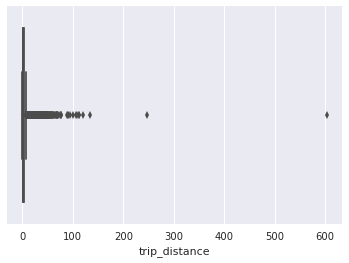

In [81]:
sns.boxplot(df_sept_cleaned['trip_distance'])

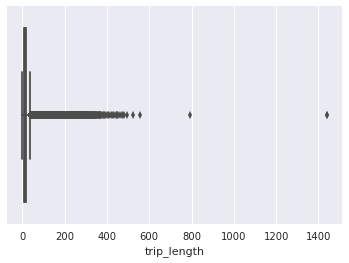

In [82]:
sns.boxplot(df_sept_cleaned['trip_length'])

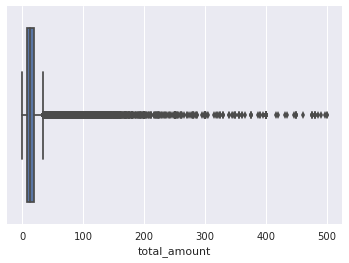

In [83]:
sns.boxplot(df_sept_cleaned['total_amount'])

It looks like it doesn't get rid of all the really dubious outliers (a 600 mile trip?!), but I feel confident it's eliminated anything that erroneously reported. Last portion of the cleanup is to update the total fare since I changed some of the fare_amounts. Total_amount should be the sum of all the dollar columns


In [78]:
df_sept_cleaned['total_amount'] = df_sept_cleaned['fare_amount'] + df_sept_cleaned['extra'] \
                                + df_sept_cleaned['mta_tax'] + df_sept_cleaned['tip_amount'] + \
                                df_sept_cleaned['tolls_amount'] + df_sept_cleaned['improvement_surcharge']

In [85]:
df_sept_cleaned.to_pickle('df_cleaned')

In [211]:
df_sept_cleaned = pd.read_pickle('df_cleaned')

## Feature Engineering ##

Given all of the exploration above, I know that there's a short list of features I want to build out. I would normally build out the categorical data as dummy variables, but I'm worried about memory issues so am just going to leave them as integers. Also based off the coordinates, I initially tried to get the start and end boroughs usung reverse_geolocator, but that was computationally expensive so I abandoned it. 
    
    Day of the week (1-7) 
    Day of month (1-31)
    Airport trip (0-3: 0 - not airport, 1 = LGA, 2 = JFK, 3 = EWR)
    Speed - MPH
    Hour (0-24)
    Tipped (boolean)
    % tip
    
I created a helper function named create_functions that'll run all of the feature engineering programmatically. Note: it's been updated to include building out trip_duration (done above in the airport evaluation) and log transformation of continuous variables (done below).

In [80]:
df_sept_cleaned.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type ', 'trip_length', 'projected_fare',
       'fare_difference'],
      dtype='object')

In [81]:
df_features = create_features(df_sept_cleaned, 'lpep_pickup_datetime', 'lpep_droppff_datetime', 'trip_distance', 
                              'trip_length', 'tip_amount', 'total_amount')

Starting off with a (1482948, 23) dataset
Added Weekdays
Added Days
Added Hours
Found 0.009795353579491661 of values in rate  to change to median 11.911439114391142
Added Rates
Added tip bool
Added tip percent
Updated 21465 trips to 1
Updated 11614 trips to 2
Updated 691 trips to 3
Now have a (1482948, 30) dataset


In [82]:
df_features = df_features.drop(['vendorid', 'store_and_fwd_flag'], 1) 

In [90]:
df_features.describe()

,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,trip_type,trip_length,projected_fare,fare_difference,weekday,day,hour,rate,tip_percent,airport
count,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,...,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06,1.482948e+06
mean,1.094860e+00,-7.393521e+01,4.074867e+01,-7.393439e+01,4.074640e+01,1.370673e+00,2.995873e+00,1.260086e+01,3.527030e-01,4.884494e-01,...,1.021871e+00,1.330723e+01,5.976600e+00,-6.624260e+00,4.174376e+00,1.547789e+01,1.353958e+01,1.323521e+01,6.650244e-02,3.150212e-02
std,5.974213e-01,4.469109e-02,5.724898e-02,5.292970e-02,5.818553e-02,1.039569e+00,3.055890e+00,9.964192e+00,3.652352e-01,7.511263e-02,...,1.462611e-01,1.179333e+01,3.056469e+00,7.944042e+00,1.961867e+00,8.522913e+00,6.797973e+00,6.999523e+00,8.835545e-02,2.212893e-01
min,1.000000e+00,-8.331908e+01,3.935694e+01,-8.342784e+01,3.942936e+01,0.000000e+00,1.000000e-02,2.500000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.666667e-02,2.504667e+00,-4.971135e+02,1.000000e+00,1.000000e+00,0.000000e+00,3.502627e-03,0.000000e+00,0.000000e+00
25%,1.000000e+00,-7.395965e+01,4.069918e+01,-7.396789e+01,4.069911e+01,1.000000e+00,1.120000e+00,6.500000e+00,0.000000e+00,5.000000e-01,...,1.000000e+00,6.166667e+00,4.103833e+00,-8.324333e+00,2.000000e+00,8.000000e+00,9.000000e+00,9.484419e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,-7.394541e+01,4.074678e+01,-7.394511e+01,4.074736e+01,1.000000e+00,1.980000e+00,9.500000e+00,5.000000e-01,5.000000e-01,...,1.000000e+00,1.038333e+01,5.205750e+00,-4.333167e+00,4.000000e+00,1.600000e+01,1.500000e+01,1.191144e+01,0.000000e+00,0.000000e+00
75%,1.000000e+00,-7.391759e+01,4.080261e+01,-7.391045e+01,4.079021e+01,1.000000e+00,3.740000e+00,1.550000e+01,5.000000e-01,5.000000e-01,...,1.000000e+00,1.711667e+01,6.980000e+00,-2.292000e+00,6.000000e+00,2.300000e+01,1.900000e+01,1.511782e+01,1.666667e-01,0.000000e+00
max,6.000000e+00,-7.100421e+01,4.317726e+01,-7.100425e+01,4.279934e+01,9.000000e+00,6.031000e+02,5.000000e+02,1.000000e+00,5.000000e-01,...,2.000000e+00,1.439400e+03,3.624490e+02,7.587117e+01,7.000000e+00,3.000000e+01,2.300000e+01,1.500000e+02,9.759650e-01,3.000000e+00


In [91]:
df_features.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ratecodeid',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type ',
       'trip_length', 'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'rate', 'tip_bool', 'tip_percent', 'airport'],
      dtype='object')

## EDA - Evaluating Features ##

In this section I'm going to visualize the interaction between the dependent variable - tip_percent, and most of the independent variables. I'm not showing every graph for efficiency, but we see that some features (payment_type) have a very strong relationship with whether someone tipped or not. 

In addition, I see a lot of outlier data and a wide distribution of distance, duration, and cost. This may skew the model and is something odf which I need to be congnizant.  


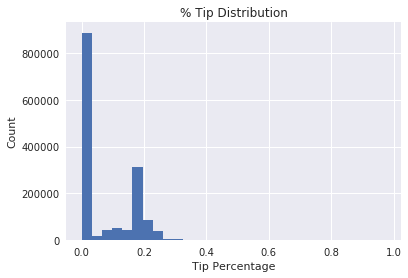

In [84]:
ax = df_features.hist('tip_percent', bins = 30)
plt.title('% Tip Distribution')
plt.xlabel('Tip Percentage')
plt.ylabel('Count')

Plotting out the distribution of the tip percent shows bimodality at 0 and under 20%. This confirms I should create a classification model first to predict if someone is going to pay tip, then a regression to predict the tip amount.

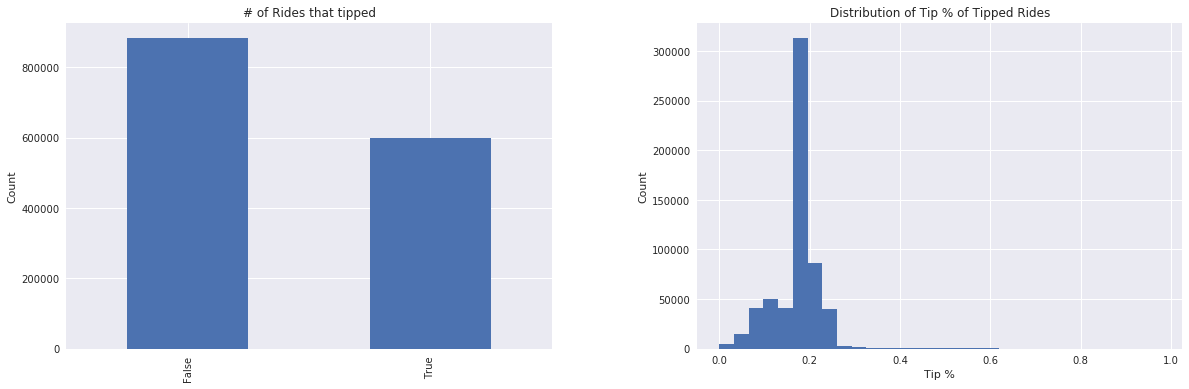

In [85]:
figure, ax = plt.subplots(1,2, figsize = (20,6))

df_features['tip_bool'].value_counts().plot(kind = 'bar', ax = ax[0])
df_features[df_features['tip_bool'] == True].hist('tip_percent', bins = 30, ax = ax[1])

ax[0].set(title = '# of Rides that tipped', ylabel = 'Count')
ax[1].set(title = 'Distribution of Tip % of Tipped Rides', xlabel = 'Tip %', ylabel = 'Count')


We don't see that imbalanced of classes - it seems that about 600k out of the 1.5MM (40%) of trips actually tipped (NYC you can do better!). Also we see that most people tip just under 18% for their trips, which is standard in NYC. Normally I'd consider rebalancing the classes but I don't think that's necessary since there's only 2 classes and in this case I'd want to downsample the larger class, which would have no effect on the regression (as it's trained on the smaller class). 

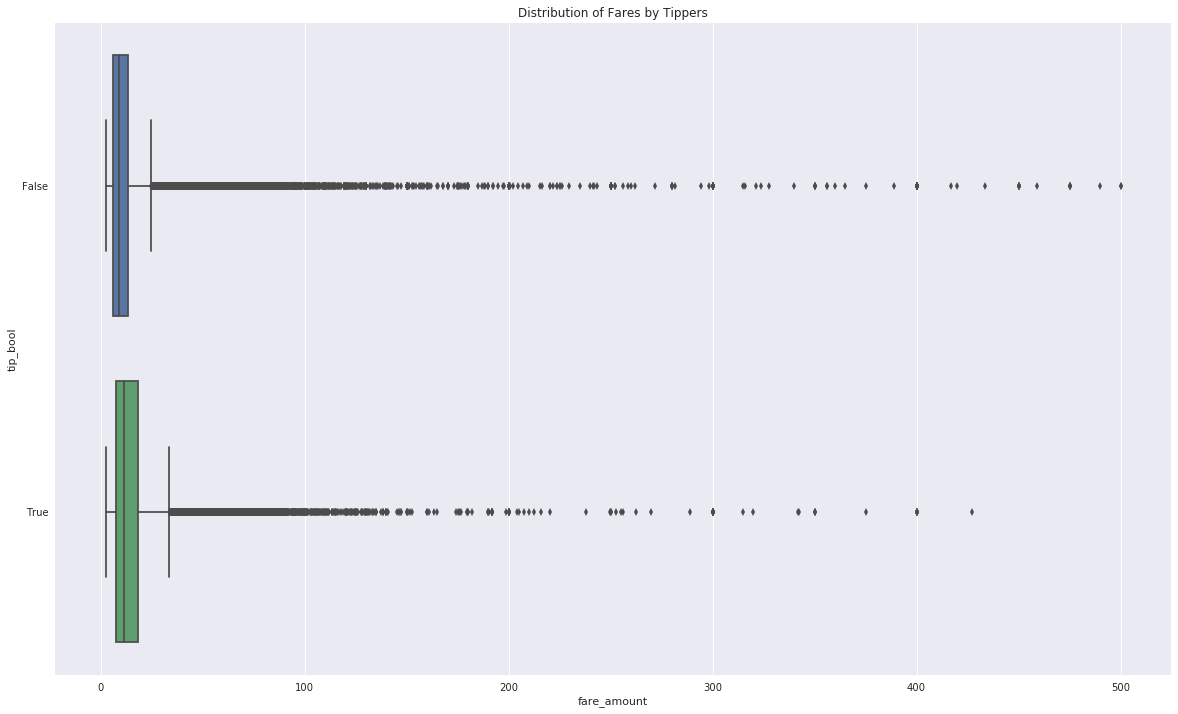

In [95]:
plt.figure(figsize = (20,12))
ax = sns.boxplot(y = 'tip_bool', x = 'fare_amount', data = df_features, orient = 'h')
ax.set(title = 'Distribution of Fares by Tippers')

Interestingly we see that while those who tip have a lower average fare, they have a wider range of fares (including outliers) than the tippers. Could it be that those with really long trips have more frustrating drives and/or feel that the fare is sufficient for payment?  


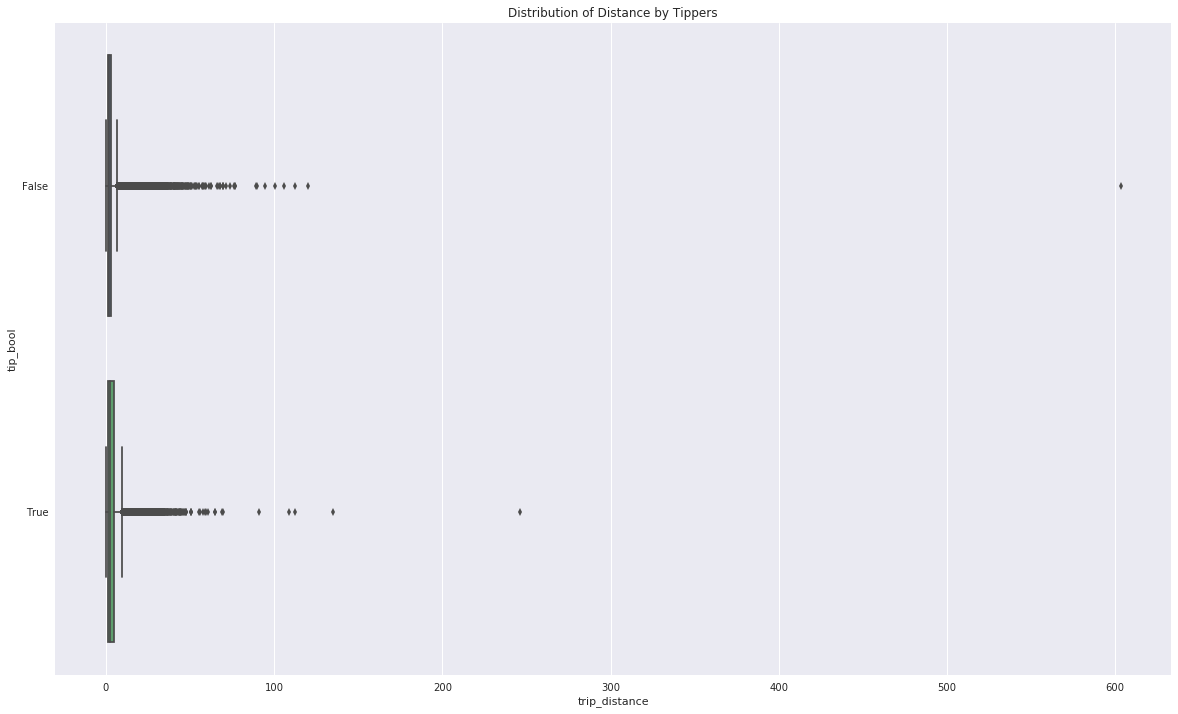

In [96]:
plt.figure(figsize = (20,12))

ax = sns.boxplot(y = 'tip_bool', x = 'trip_distance', data = df_features, orient = 'h')
ax.set(title = 'Distribution of Distance by Tippers')

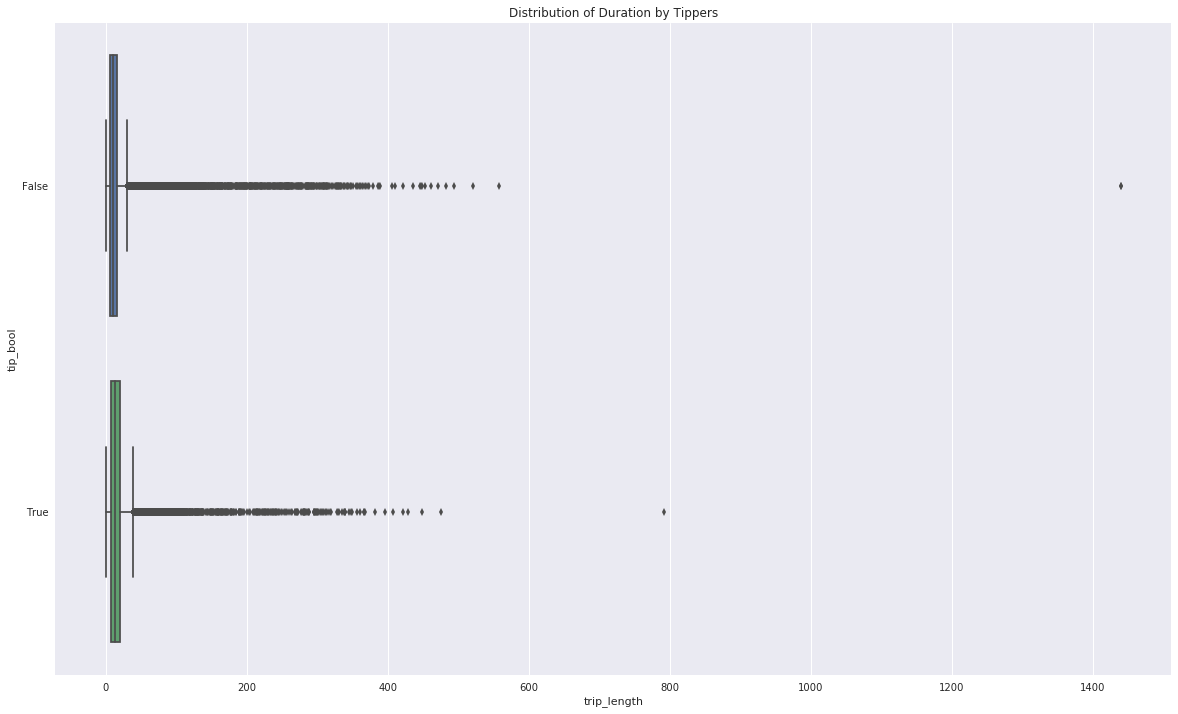

In [97]:
plt.figure(figsize = (20,12))

ax = sns.boxplot(y = 'tip_bool', x = 'trip_length', data = df_features, orient = 'h')
ax.set(title = 'Distribution of Duration by Tippers')

Because of the outliers, we can't see that much more information based on trip duration or distance. 

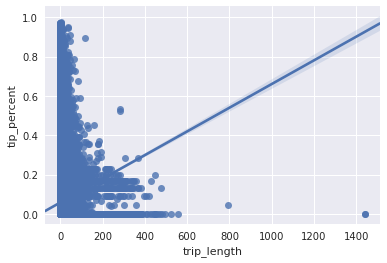

In [98]:
sns.regplot(x = 'trip_length', y = 'tip_percent', data = df_features)

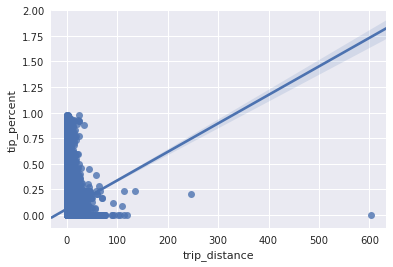

In [99]:
sns.regplot(x = 'trip_distance', y = 'tip_percent', data = df_features)

At a cursory glance there's a positive linear relationship between trip distance, length and tips at least so these will be useful in the model I build out.

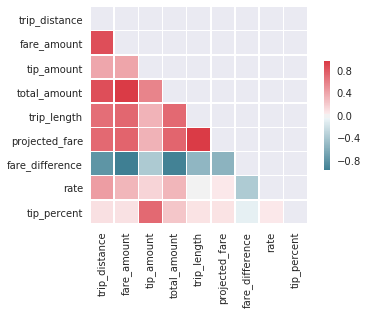

In [100]:
cont_var = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_length', 
            'projected_fare', 'fare_difference', 'rate', 'tip_percent']
corr = df_features[cont_var].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Plotting out the correlation matrix for all the continuous variables, we see some obvious correlations as many of the variables are derived from each other/linearly related. However, I'm sad to see that fare_difference has a weak relationship with tipping amount. 

We had a very long right tail for most of the continuous variables, so I'm going to plot out the distributions again.   

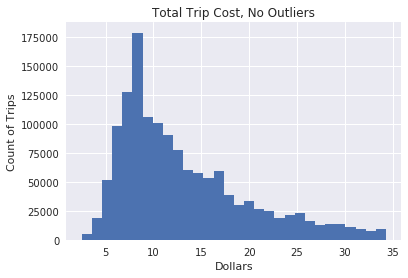

In [101]:
ax = df_features[df_features['total_amount'] < \
                3*df_features['total_amount'].std()].hist('total_amount', bins = 30)

plt.xlabel('Dollars')
plt.ylabel('Count of Trips')
plt.title('Total Trip Cost, No Outliers')


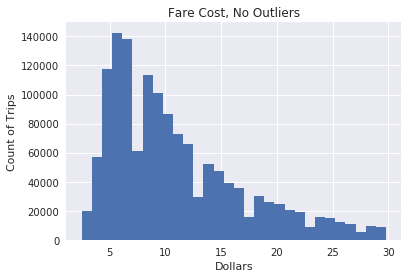

In [86]:
ax = df_features[df_features['fare_amount'] < \
                3*df_features['fare_amount'].std()].hist('fare_amount', bins = 30)

plt.xlabel('Dollars')
plt.ylabel('Count of Trips')
plt.title('Fare Cost, No Outliers')


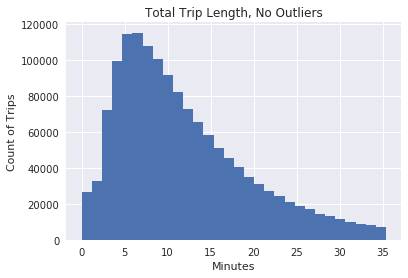

In [87]:
ax = df_features[df_features['trip_length'] < \
                3*df_features['trip_length'].std()].hist('trip_length', bins = 30)

plt.xlabel('Minutes')
plt.ylabel('Count of Trips')
plt.title('Total Trip Length, No Outliers')

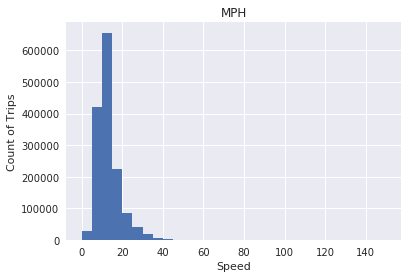

In [104]:
ax = df_features.hist('rate', bins = 30)

plt.xlabel('Speed')
plt.ylabel('Count of Trips')
plt.title('MPH')

Visualizing these features shows that most of them are lognormal. Let's do a log transformation on the data and use those log features to run some models!

In [88]:
cont_features = ['trip_length', 'rate', 'total_amount', 'fare_amount', 'trip_distance'] 
log_trans_features(df_features, cont_features)

In [89]:
df_features.columns #confirming the new columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ratecodeid',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type ',
       'trip_length', 'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'rate', 'tip_bool', 'tip_percent', 'airport', 'trip_length_log',
       'rate_log', 'total_amount_log', 'fare_amount_log', 'trip_distance_log'],
      dtype='object')

Let's quickly evaluate some of the categorical data (payment_type, ratecodeid, trip_type) as well.

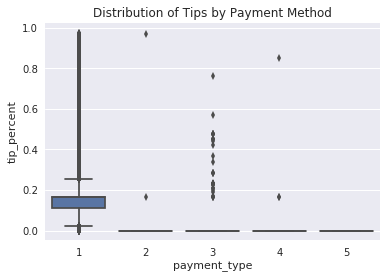

In [107]:
ax = sns.boxplot(x = 'payment_type', y = 'tip_percent', data = df_features)
ax.set(title = 'Distribution of Tips by Payment Method')

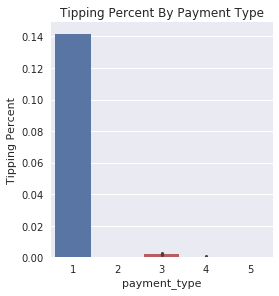

In [108]:
ax = sns.factorplot(x = 'payment_type', y = 'tip_percent', data = df_features, kind = 'bar')

ax.despine(left=True)
ax.set(ylabel = "Tipping Percent", title = 'Tipping Percent By Payment Type')

Wow it looks like most of the tips made were through credit card transactions. This should be a strong feature to use

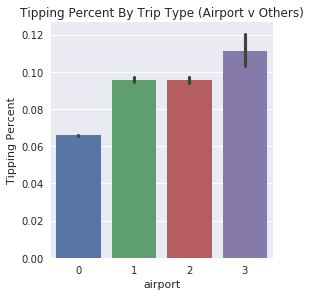

In [109]:
ax = sns.factorplot(x = 'airport', y = 'tip_percent', data = df_features, kind = 'bar')

ax.despine(left=True)
ax.set(ylabel = "Tipping Percent", title = 'Tipping Percent By Trip Type (Airport v Others)')

I can run a t-test to confirm the significance of trip type for tipping amount, but based off this graph and the small std lines, I'm going to assume this will also be a great feature to use

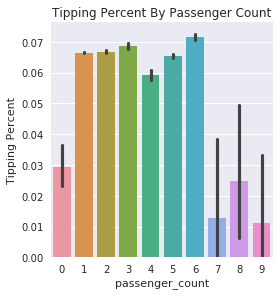

In [110]:
ax = sns.factorplot(x = 'passenger_count', y = 'tip_percent', data = df_features, kind = 'bar')

ax.despine(left=True)
ax.set(ylabel = "Tipping Percent", title = 'Tipping Percent By Passenger Count')

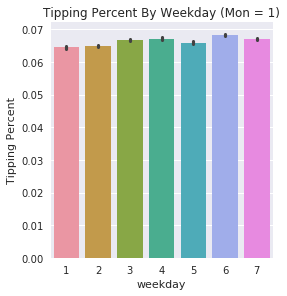

In [112]:
ax = sns.factorplot(x = 'weekday', y = 'tip_percent', data = df_features, kind = 'bar')

ax.despine(left=True)
ax.set(ylabel = "Tipping Percent", title = 'Tipping Percent By Weekday (Mon = 1)')

In [20]:
df_features.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ratecodeid',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type ',
       'trip_length', 'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'rate', 'tip_bool', 'tip_percent', 'airport', 'trip_length_log',
       'rate_log', 'total_amount_log', 'fare_amount_log', 'trip_distance_log'],
      dtype='object')

It looks like people tip consistently regardless of DOW. 

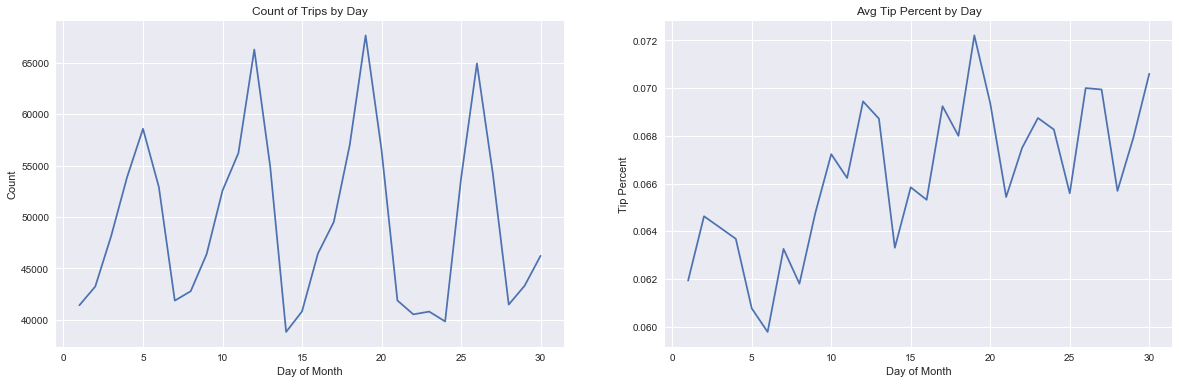

In [39]:
figure, ax = plt.subplots(1,2, figsize = (20,6))
ax[0].plot(df_features.groupby('day')['day'].count())
ax[0].set(xlabel = 'Day of Month', ylabel = 'Count', title = 'Count of Trips by Day') 

ax[1].plot(df_features.groupby('day')['tip_percent'].mean())
ax[1].set(xlabel = 'Day of Month', ylabel = 'Tip Percent', title = 'Avg Tip Percent by Day') 

For the most part it looks like green cab trips are cyclical by week, except for Sept 5th. This might be because of Labor Day weekend when people are out of the city, which was the 7th. This would make sense because the 7th seems to have higher trips than usual, which would correspond to people coming back into the city.

Coincidentally tip percent seems to plummet during that holiday weekend as week. Perhaps tourists, who are likely to be the ones in the city during a holiday weekend, are worst tippers than natives.

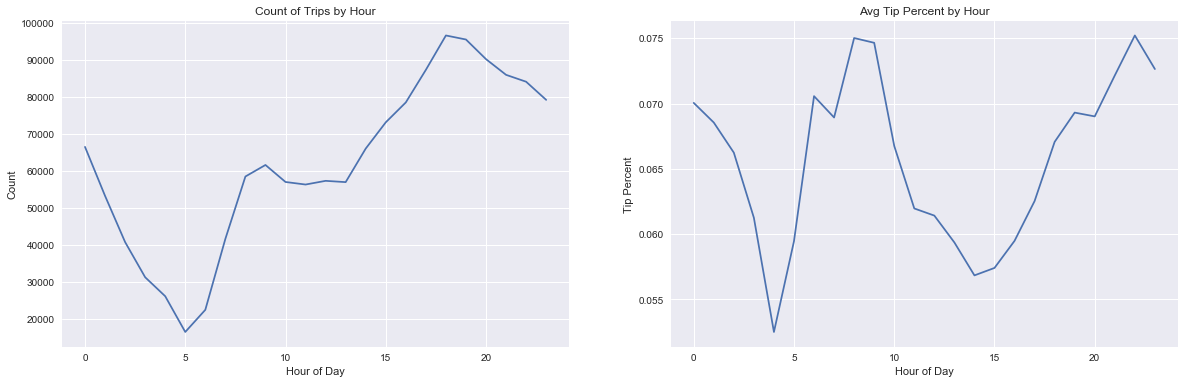

In [41]:
figure, ax = plt.subplots(1,2, figsize = (20,6))
ax[0].plot(df_features.groupby('hour')['hour'].count())
ax[0].set(xlabel = 'Hour of Day', ylabel = 'Count', title = 'Count of Trips by Hour') 

ax[1].plot(df_features.groupby('hour')['tip_percent'].mean())
ax[1].set(xlabel = 'Hour of Day', ylabel = 'Tip Percent', title = 'Avg Tip Percent by Hour') 

In [113]:
df_features.to_pickle('df_features')

## Modeling ##


Based off the EDA, I've decided to break out the model into 2 stages:

1) Predict if someone tipped.  
2) Predict the tipped amount if so. 

This will allow me to train the regression model on only non-zero values, which should increase its accuracy. 

Since I'm building 2 submodels within my model itself, I'm going to do train/test splits for each submodel as well to evaluate overfitting. Luckily the dataset is large enough to accomodate this. 

I quickly evaluate which model does best through cross-validation, evaluating AUC and MSE for classification and regression problems respectively. I then tune the hyperparameters of the best model using a gridsearch CV. 

I'll confirm the performance of the hyperparameters by rerunning the cross-validation a second time with the best parameters. 

Lastly, I validate the model with the holdout. 

I've chosen to use all of the data available because I'm a completionist. However, I'm dropping any fields that are directly related to tip_percent i.e. total_amount & tip_amount since the presumption is we wouldn't have this data with a predictor (and it would be cheating).

### Tip Classifier ### 

Creating a binary classifier should be relatively straightforward given all the feature engineering I performed. 

I'm evaluating the following models:  
1) Logistic - great at binary classification. Easy to adapt to new data if necessary and to adjust decision boundaries.  
2) Guassian Naive Bayes - very quick model to run. Typically not the best, but I like to throw it in because of it's expediency.   
3) Ensembles - AdaBoost, Random Forests, XGBoost. These are all models that traditionally work well for classification problems with minimal hyperparameters to tune. Best of all they're great at showing feature importance.     

After some cross-validations, I find XGBoost to be the best performing classifier. Overall, after some minor optimizations, the classifier has a .95 AUC and a .94 f1 score so it's pretty powerful.


In [149]:
feats_log = ['ratecodeid', 'passenger_count',
       'extra', 'mta_tax',  'tolls_amount',
       'improvement_surcharge', 'payment_type', 'trip_type ',
        'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'airport', 'trip_length_log',
       'rate_log', 'fare_amount_log', 'trip_distance_log'] 

In [150]:
X, X_holdout, y, y_holdout = train_test_split(df_features[feats_log], 
                                                    df_features[['tip_percent', 'tip_bool']], test_size = .25)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y['tip_bool'], test_size = .25)

In [101]:
logr = LogisticRegression()
naive = GaussianNB()
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()

In [102]:
scoreslog = cross_val_score(logr, X_train, y_train, cv = 5, scoring = 'roc_auc')
print("Logistic Regression: ",np.mean(scoreslog))

Logistic Regression:  0.953368210292


In [103]:
scoresNB = cross_val_score(naive, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('Naive Bayes: ', np.mean(scoresNB))

Naive Bayes:  0.953961440538


In [104]:
scoresRFC = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('Random Forests: ', np.mean(scoresRFC))

Random Forests:  0.950820364785


In [105]:
scoresADA = cross_val_score(ada, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('ADA: ', np.mean(scoresADA))

ADA:  0.955292754906


In [106]:
scoresXB = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('XGBoost: ', np.mean(scoresXB))

XGBoost:  0.955885481568


Out of all the models ran, AdaBoost and XGBoost performed the best with a AUCs over .954. I'm opting for XGBoost since it converges much faster. 

I'm going to run a grid search on the XGBoost to tune the hyperparameters, namely the n_estimators of trees that we generate. 

In [115]:
treesr_param = {'n_estimators' : [50, 75, 100, 125, 150, 175, 200], 
                'reg_lambda' : [.01, .02, .04, .08, .16, .32, .64, 1.28, 2.56, 5.12, 10.24]}

In [116]:
grid = GridSearchCV(xgb, treesr_param, scoring = 'roc_auc', cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'reg_lambda': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [117]:
print('Top parameter: ', grid.best_params_)
print('Top AUC score: ', grid.best_score_)

Top parameter:  {'n_estimators': 200, 'reg_lambda': 2.56}
Top AUC score:  0.956390136289


In [118]:
print('XGBoost Optimized: ', np.mean(cross_val_score(grid.best_estimator_, X_train, y_train, cv = 5, scoring = 'roc_auc')))

XGBoost Optimized:  0.956390135553


Great - it looks like 200 trees with some L2 regularization helps with the prediction model. Let's see what are the most important features are in the prediction model.

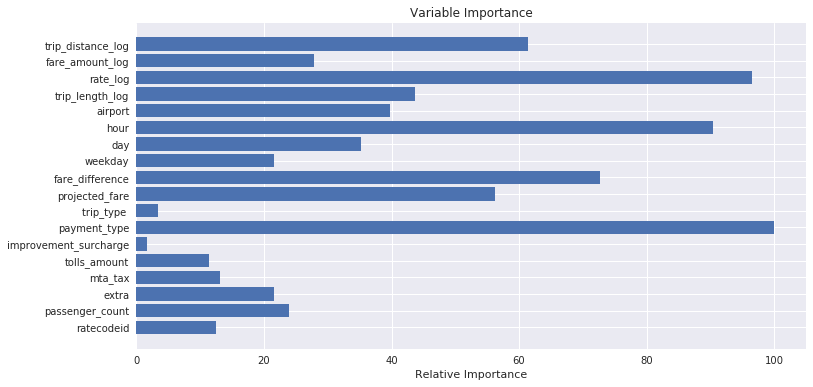

In [119]:
# code adapted from SKLearn
feature_importance = grid.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
plt.figure(figsize = (12,6))
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats_log)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Payment type (due to credit card usage), the log transformation of speed, hour of the day, and log transformation of the trip distance are the best features for determining wither someone tipped or not. 

In [120]:
classification_report(y_test, grid.best_estimator_.predict(X_test))

'             precision    recall  f1-score   support\n\n      False       1.00      0.90      0.94    165661\n       True       0.87      0.99      0.93    112392\n\navg / total       0.94      0.94      0.94    278053\n'

AUC: 0.945025441909


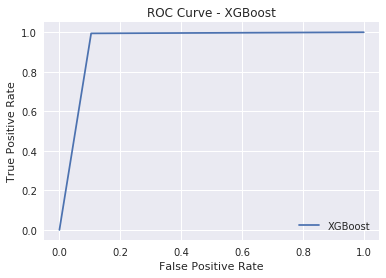

In [121]:
roc = roc_curve(y_test, grid.best_estimator_.predict(X_test))

plt.plot(roc[0], roc[1], label = 'XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()

print('AUC:', roc_auc_score(y_test, grid.best_estimator_.predict(X_test)))

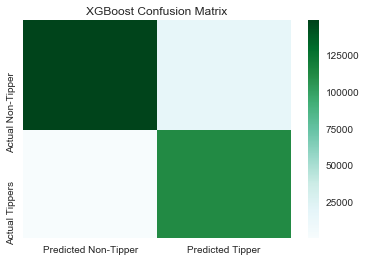

In [155]:
sns.heatmap(confusion_matrix(y_test, grid.best_estimator_.predict(X_test)), 
            xticklabels = ['Predicted Non-Tipper', 'Predicted Tipper'], 
            yticklabels = ['Actual Non-Tipper', 'Actual Tippers'], 
            cmap = "BuGn")
plt.title("XGBoost Confusion Matrix")

It seems that this model is a little overeager to predict tipping - it has a 99% recall rate for tipping. In the future I can adjust the class weights and try to optimize this. However, for now it's good enough as is.  

In [158]:
joblib.dump(grid.best_estimator_, 'XGBClassoptimized')

['XGBClassoptimized']

### Regression Model ###

Now onto the regression model. Since I have a predictor of whether someone will tip, I can exclude any 0 tip data for my regression model. 

I'm going to try to focus this regression on ensemble regressors since they're designed to minimize overfit. I'm using Mean Squared Error as the evaluation criteria to try to create a predictor with the least amount of bias overall.

I try many different models below and settle on XGB Regressor since it provides the best results and is fast to converge. Through grid search I find that some L2 regularization is needed. Overall, the regressor is great at minimizing MSE - overall it predicts within .25% away from the actual tip percent. 

The top features of my regression model were all engineered - fare_difference, log(rate), and projected_fare all make sense as being worthwhile of a higher tip.  

In [158]:
indices = y[y['tip_bool'] == 1].index

In [159]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X.loc[indices, feats_log], 
                                                    y[y['tip_bool'] == 1]['tip_percent'], test_size = .25)

As a benchmark let's run a simple Linear Regression

In [170]:
lin = LinearRegression()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgr = XGBRegressor()

In [15]:
scoreslin = cross_val_score(lin, Xr_train, yr_train, cv = 5, scoring = 'neg_mean_squared_error')
print('Linear Regression: ', abs(np.mean(scoreslin)))

Linear Regression:  0.00287921026504


In [128]:
scoresrfr = cross_val_score(rfr, Xr_train, yr_train, cv = 5, scoring = 'neg_mean_squared_error')
print("Random Forest: ",abs(np.mean(scoresrfr)))

Random Forest:  0.00297986462132


In [129]:
scoresgbr = cross_val_score(gbr, Xr_train, yr_train, cv = 5, scoring = 'neg_mean_squared_error')
print("Gradient Boosting: ",abs(np.mean(scoresgbr)))

Gradient Boosting:  0.00259158064324


In [133]:
scoresgbr = cross_val_score(xgr, Xr_train, yr_train, cv = 5, scoring = 'neg_mean_squared_error')
print("XGB: ",abs(np.mean(scoresgbr)))

XGB:  0.00259135138541


The XGBoosting Regressor performs the best of the 4 models we're evaluating (again it's also the fastest of the ensembles), so I'm going to optimize the parameters. However, this time I'm going to also adjust some of the L2 regularization parameters and the learning rate to account for overfitting. 

In [26]:
treesr_param = {'n_estimators' : [50, 75, 100, 125, 150, 175, 200], 
                'reg_lambda' : [.01, .02, .04, .08, .16, .32, .64, 1.28, 2.56, 5.12, 10.24],
               'learning_rate' : [0.01, 0.02, 0.05, .1]}

In [27]:
gridr = GridSearchCV(xgr, treesr_param, scoring = 'neg_mean_squared_error', cv = 5)
gridr.fit(Xr_train, yr_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'reg_lambda': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24], 'learning_rate': [0.01, 0.02, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [28]:
print('Top parameter: ', gridr.best_params_)
print('Avg MSE: ', abs(gridr.best_score_))

Top parameter:  {'learning_rate': 0.1, 'n_estimators': 150, 'reg_lambda': 5.12}
Avg MSE:  0.00257999673281


It looks like the top number of trees is 150 with some regularization. Let's cross-validate these results. 

In [126]:
print('XGBoost Optimized MSE: ', abs(np.mean(cross_val_score(gridr.
                                                             best_estimator_, Xr_train, yr_train, cv = 5, scoring 
                                                             = 'neg_mean_squared_error'))))
print('XGBoost Optimized R^2: ', abs(np.mean(cross_val_score(gridr.
                                                             best_estimator_, Xr_train, yr_train, cv = 5, scoring 
                                                             = 'r2'))))


XGBoost Optimized MSE:  0.00257999650588
XGBoost Optimized R^2:  0.184893626192


Hmmm, when evaluating the R^2, the XGBoost Regressor produces a pretty unstable and possibly overfit model. It's because of all the outliers in the data that the tree tries to fit into. While I'm trying to minimize MSE, I want to make sure the model has good predictive power too. I tried doing some random forests regression to model it as well, but got similar R^2.


In [50]:
xgbr_optimized = gridr.best_estimator_

Let's visualize the residuals of the predictions and make sure that there's no heteroskedasticity 

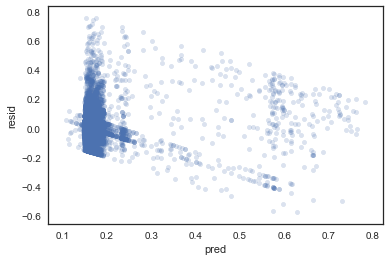

In [160]:
df_test = Xr_test.copy()
df_test['pred'] = xgbr_optimized.predict(Xr_test)
df_test['resid'] = yr_test - df_test['pred']

with sns.axes_style('white'):
    plot = df_test.plot(kind='scatter', x='pred', y='resid', alpha = .2)
        

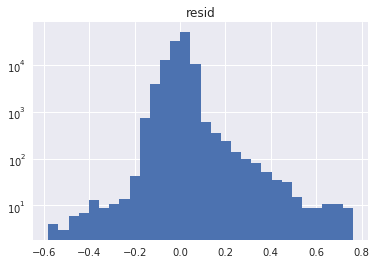

In [47]:
df_test.hist('resid', bins = 30)
plt.yscale('log')

Ok - we see some issues here with the residuals. 

1) There's some heteroskedasticity, meaning there's no constant variance with the errors. There's a lower bound of around -.2 in the first graph, implying the model is more likely to overestimate than underestimate tip percentage. Attempts with an L1 regularization (alpha = .04, found by gridsearch) show similar results


Luckily the residuals are roughly centered around 0. Let's evaluate the model as a whole.  

In [175]:
best_features = xgbr_optimized.booster().get_fscore()

In [197]:
feats = []
weights = []
for x, y in best_features.items():
    feats.append(x)
    weights.append(y) 

rel_weights = [100.0 * (x / max(weights)) for x in weights]

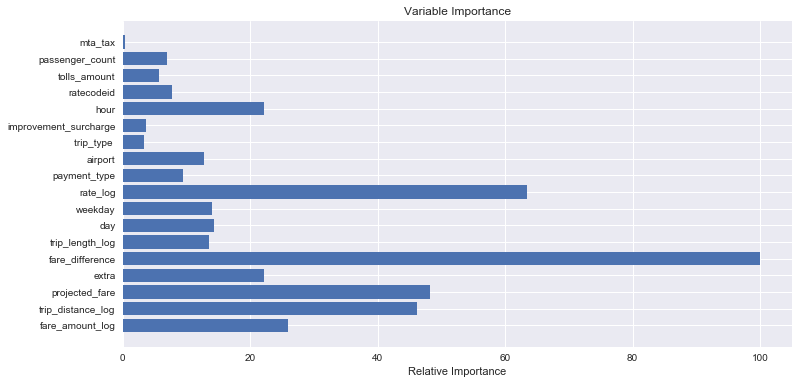

In [198]:
pos = range(len(feats))
plt.figure(figsize = (12,6))
plt.barh(pos, rel_weights, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
joblib.dump(xgbr_optimized, 'xgbr_optimized')

## Pulling it all together ## 

I created the helper code predict_model which uses the pickled models developed above for ease. As you can see the model performs decently well - with a .0029 MSE and a R^2 value of .63. My model primarily works because of the classifier - 98% of the tips paid out were used with credit cards, which my classification model weighs the heaviest out of all the features. This incredibly high amount leads me to think that there's severe underreporting of tips when it comes to cash transactions - drivers are pocketing most of these dollars under the table, so effectively my model is great at predicting credit card tip percentage. 

In the future, I could improve this model through a variety of ways:

1) SVM & Neural Nets - SVM performs well with outlier data which I could incorporate into a future regressor. In addition, NNs are great at learning feature interactions so could detect a significant new feature that would improve the model. However, both are computationally taxing so I opted against them for this exercise. 
    
2) Stacking models together - I could build out the various regressors tested and stack all the models together to create an ensemble model with lowered variance. In addition, I could build out a regression model without any outliers to stack into the main model, which should reduce the overestimation in my model. 

3) Pull in relevant geo-data - I attempted this in the beginning but hit some roadblocks in terms of computation and rate limiting, but neighborhoods could have a significant impact on tip percentage. I would evaluate whether pickups/dropoffs at restaurant and bar-dense neighborhoods late at night have higher tipping rates. Hypothetically these exchanges might have higher credit card transaction rates (and there might be an inebriation effect), thus have increased tip percentages.   
  



In [ ]:
"""def predict_model(df):        
    classifier = joblib.load('XGBClassoptimized') 
    regressor = joblib.load('xgbr_optimized')
    feats_log = ['ratecodeid', 'passenger_count',
       'extra', 'mta_tax',  'tolls_amount',
       'improvement_surcharge', 'payment_type', 'trip_type ',
        'projected_fare', 'fare_difference', 'weekday', 'day',
       'hour', 'airport', 'trip_length_log',
       'rate_log', 'fare_amount_log', 'trip_distance_log'] 
    classes = classifier.predict(df[feats_log])
    prediction = regressor.predict(df[feats_log])
    return classes*prediction"""

In [163]:
df_pred = y_holdout.copy()
df_pred['pred'] = predict_model(X_holdout)
df_pred['resid'] = df_pred['tip_percent']-df_pred['pred']

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [164]:
print ("mean_squared_error:", mean_squared_error(df_pred['tip_percent'],df_pred['pred']))
print ("r2_score:", r2_score(df_pred['tip_percent'],df_pred['pred']))

mean_squared_error: 0.00292028485549
r2_score: 0.626194486514


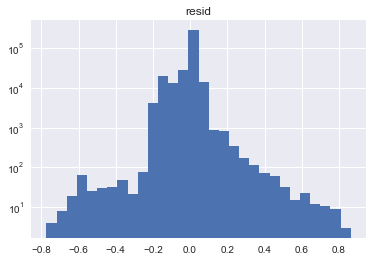

In [165]:
df_pred.hist('resid', bins = 30)
plt.yscale('log')

The residuals seem to center around 0, which indicates good performing model. 

## Anomaly Detection ##

Option D: Anomaly Detection
What anomalies can you find in the data? Did taxi traffic or behavior deviate from the norm on a particular day/time or in a particular location?
Using time-series analysis, clustering, or some other method, please develop a process/methodology to identify out of the norm behavior and attempt to explain why those anomalies occurred.


One of the things I noticed in the dataset is the potential for fraud in the taxi data, especially when it comes to cash transactions. I define fraud as cash transactions with high fare_amounts compared to a low travel distance or time duration. I was able to manually identify over 6k transactions that lasted less than a minute, went 0 distance, but accounted for tens of thousands in revenue in just Sept alone. Above I tried to exclude some of these potential data points by calculating the projected fare given these parameters, but I tried building that out further by creating an anomaly detection model.  

I'm working with a cash only dataset (payment_type == 2) and will clean the data/add the same features I worked with above. However, I will leave in outliers purposefully and only clean out data that is obviously erroneous, dropping bad ratecodeids, 0 coordinate trips, and fares that are less than $2.5.

My anomaly detector ultimately can detect the long tail for lengthy and expensive cash trips, but not necessarily those far away. These can be proxies for very terrible traffic conditions or drivers who chose suboptimal routes and thus gouge their customers. Attempts to identify the perceived fraud were unsuccessful. Attempts to cluster anomalies together to derive some learnings were too succesful (cluster of 1 for DBScan). 



In [5]:
df_sept = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')

In [107]:
df_cash = clean_data(df_sept[df_sept['Payment_type'] == 2])

Changed all the dollar amounts
Added Duration


In [108]:
df_cash = create_features(df_cash)

Starting off with a (780112, 21) dataset
Added Weekdays
Added Days
Added Hours
Found 0.0012818672190659803 of values in rate  to change to median 11.412103746397696
Added Rates
Added tip bool
Added tip percent
Updated 7965 trips to 1
Updated 3892 trips to 2
Updated 178 trips to 3
Now have a (780112, 33) dataset


In [109]:
indices = find_airport(df_cash, 'pickup_latitude', 'pickup_longitude', 
                                  'dropoff_latitude', 'dropoff_longitude', (0,0), (0,0)).index
df_cash = df_cash.drop(indices)
print('Dropped '  + str(indices.shape[0]) +' rows with 0 coordinates')

rindices = df_cash[df_cash['ratecodeid'] > 7].index
df_cash = df_cash.drop(rindices)    
print('Dropped '  + str(rindices.shape[0]) +' rows with invalid rate codes')

findices = df_cash[(df_cash['fare_amount'] < 2.5) | (df_cash['total_amount'] < 2.5)].index
df_cash = df_cash.drop(findices)    
print('Dropped '  + str(findices.shape[0]) +' rows with invalid cash values (< 2.5)')

Dropped 1963 rows with 0 coordinates
Dropped 0 rows with invalid rate codes
Dropped 494 rows with invalid cash values (< 2.5)


In [110]:
df_cash = df_cash.reset_index().drop('index', 1)

Let's do some quick EDA of cash only transactions

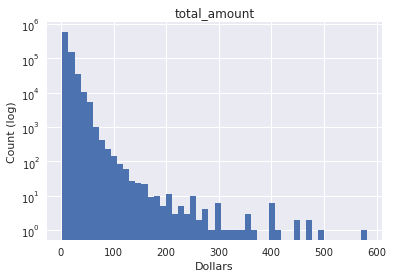

In [23]:
df_cash.hist('total_amount', bins = 50)
plt.yscale('log')
plt.ylabel('Count (log)')
plt.xlabel('Dollars')

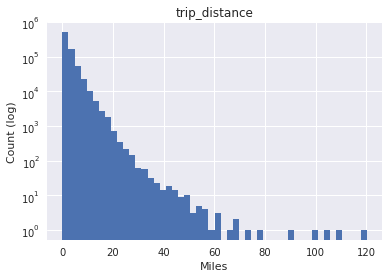

In [24]:
df_cash.hist('trip_distance', bins = 50)
plt.yscale('log')
plt.ylabel('Count (log)')
plt.xlabel('Miles')

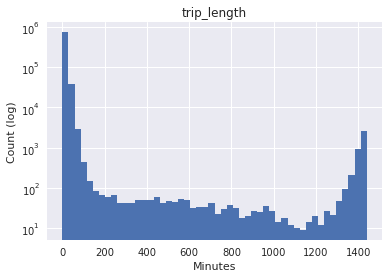

In [27]:
df_cash.hist('trip_length', bins = 50)
plt.yscale('log')
plt.ylabel('Count (log)')
plt.xlabel('Minutes')

We can still see a very wide spread of trips in terms of length, etc even with cash transactions. However, the trip_length distribution looks parabolic compared to distance and total amount (even though they should be related). Is this an indication of broken timers? Hopefully my anomaly detector might shed some insight as to this incongruity.

In [178]:
df_cash['anomaly'] = 1
a_indices = df_cash[(df_cash['trip_length'] < 1) & (df_cash['trip_distance'] == 0)].index
df_cash.loc[a_indices, 'anomaly'] = -1

In [21]:
features = ['trip_distance', 'trip_length', 'total_amount']

In [30]:
params = {"n_estimators": [50, 75, 100], 
      'contamination': [.001, .002, .004, .008, .016, .032]}
iso = IsolationForest()


In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(df_cash[features])

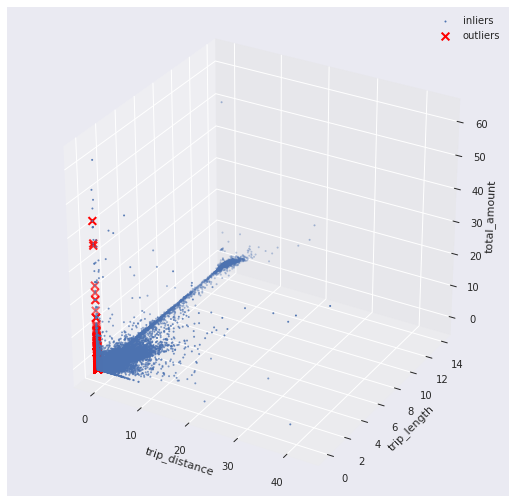

In [24]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("trip_distance")
ax.set_ylabel("trip_length")
ax.set_zlabel("total_amount")

ax.scatter(X[:, 0], X[:, 1], zs=X[:, 2], s=4, lw=0, label="inliers")
ax.scatter(X[a_indices, 0], X[a_indices, 1], X[a_indices, 2],  
           lw=2, s=60, marker="x", c="red", label="outliers")

ax.legend()

Plotting out the anomalies into by trip_distance, total_fare, and trip_duration you can see that they appear to be distant far from the rest of the data. Also it seems like there are some outliers that we're not capturing, meaning an anomaly detector would be helpful in this case.  

Since there are relatively few anomalies in the dataset, I need to use stratified k-folds in my cross-validation to try to make each fold as representative as possible. I'm evaluating the anomaly model by recall, since I'm not entirely sure what constitutes an anomaly and want it to be as greedy as possible for now. 

For this model, I'm using an IsolationForest since it performs well at anomaly detection at high dimensions and typically performs better than OneClassSVM and LocalOutlierFactors.

In [31]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, df_cash['anomaly'], test_size = .20)
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(X2_train, y2_train))

grida = GridSearchCV(iso, params, scoring='recall', cv=folds)
grida.fit(X2_train, y2_train)

GridSearchCV(cv=[(array([204511, 204596, ..., 622122, 622123]), array([     0,      1, ..., 207400, 207401])), (array([     0,      1, ..., 622122, 622123]), array([204511, 204596, ..., 414757, 414758])), (array([     0,      1, ..., 414757, 414758]), array([413884, 413977, ..., 622122, 622123]))],
       error_score='raise',
       estimator=IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 75, 100], 'contamination': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [101]:
print('Top parameter: ', grida.best_params_)
print('Avg Recall: ', grida.best_score_)

Top parameter:  {'contamination': 0.001, 'n_estimators': 100}
Avg Recall:  0.998988362117


In [45]:
pred = pd.Series(grida.best_estimator_.predict(X2_train).reshape(-1))

In [49]:
pred = pd.Series(grida.best_estimator_.predict(X2_train).reshape(-1))
a_pred_indices = pred[pred == -1].index

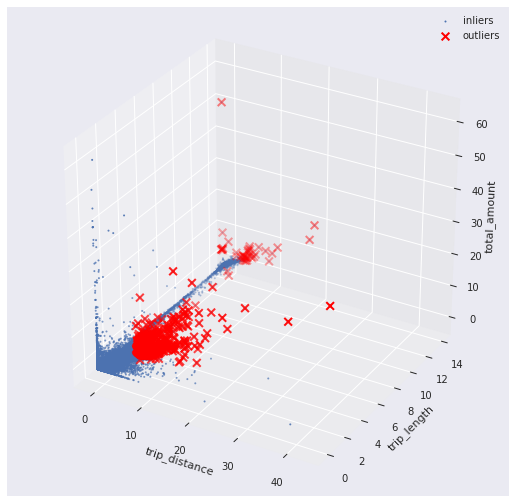

In [67]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("trip_distance")
ax.set_ylabel("trip_length")
ax.set_zlabel("total_amount")

ax.scatter(X2_train[:, 0], X2_train[:, 1], zs=X2_train[:, 2], s=4, lw=0, label="inliers")
ax.scatter(X2_train[a_pred_indices, 0], X2_train[a_pred_indices, 1], X2_train[a_pred_indices, 2],  
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()

I can't get a model to work that will identify these the cash data as anomalies, even when adding in more features, so I think I'll drop it for now since it's proving hard to identify and may just be a fluke - I tried a multivariate guassian regression as well to try to id these but with no success. It must not be statistically improbable. However, the model is good at picking up distance x length x price outliers so let's evaluate that further.

In [111]:
df_results = df_cash
df_results['pred'] = grida.best_estimator_.predict(X)

In [168]:
joblib.dump(grida.best_estimator_, 'iso_distance_time')

['iso_distance_time']

In [115]:
df_results[df_results['pred'] == -1].shape

(790, 34)

My model found 790 anomalies; let's run a cluster analysis and see if there's any generalizations we can make. Luckily it's so small that I can one-hot encode some of the categorical data to run a DBScan, since I'm unsure of how many clusters there are. Values need to be rescaled for the scan. 

In [153]:
df_anomalies = df_results[df_results['pred'] == -1]

In [130]:
df_anomalies = pd.get_dummies(df_anomalies, columns = ['day', 'hour', 'weekday', 'airport'])

In [182]:
df_anomalies = df_anomalies.drop(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 
       'payment_type', 'trip_type ',  'tip_bool', 'trip_length_log',
       'rate_log', 'total_amount_log', 'fare_amount_log', 'trip_distance_log',
       'pred'], 1)

In [139]:
X_anomalies = scaler.fit_transform(df_anomalies)

In [169]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3).fit(X_anomalies)

print('# of clusters: ',len(set(db.labels_)))

# of clusters:  1


Unfortunately that doesn't yield any good results - let's visualize the data to see the vectorized data points

In [170]:
pca2 = PCA(n_components=2) 
X_pca2 = pca2.fit_transform(X_anomalies)

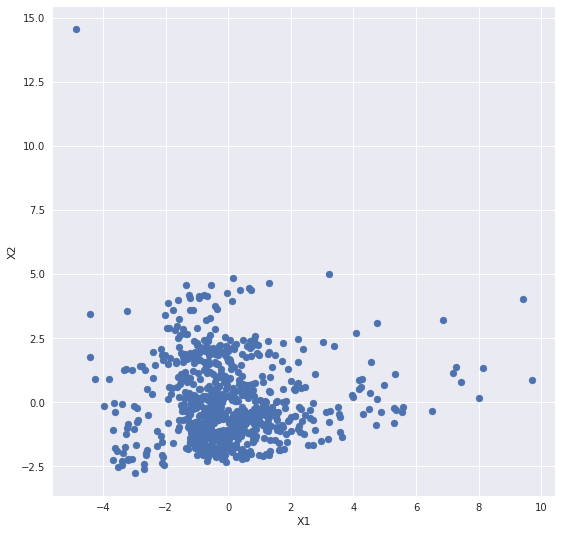

In [171]:
plt.figure(figsize = (9,9))
plt.scatter(X_pca2[:, 0], X_pca1[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")


Yep - the outliers mostly cluster together so there's no way I can segment out these datapoints unfortunately. Let's try to do some visualizations to get a general sense of these outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cd26b8400>]], dtype=object)

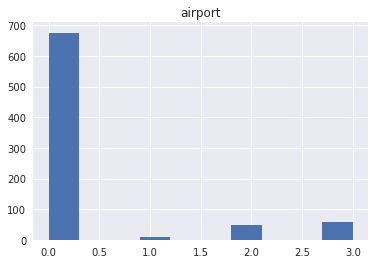

In [185]:
df_anomalies.hist('airport')

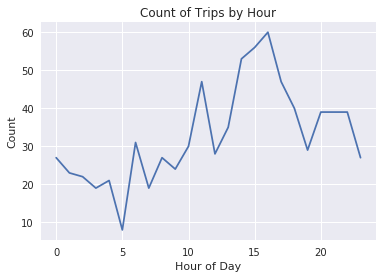

In [188]:
plt.plot(df_anomalies.groupby('hour')['hour'].count())
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Count of Trips by Hour') 


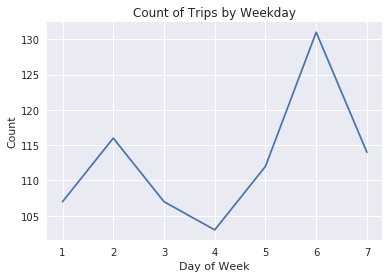

In [200]:
plt.plot(df_anomalies.groupby('weekday')['weekday'].count())
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Count of Trips by Weekday') 


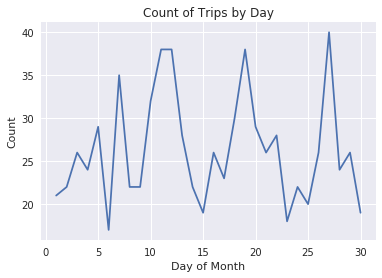

In [220]:
plt.plot(df_anomalies.groupby('day')['day'].count())
plt.xlabel('Day of Month')
plt.ylabel('Count')
plt.title('Count of Trips by Day') 

In [212]:
df = df_anomalies.groupby(['weekday', 'hour'])['total_amount'].count().reset_index()

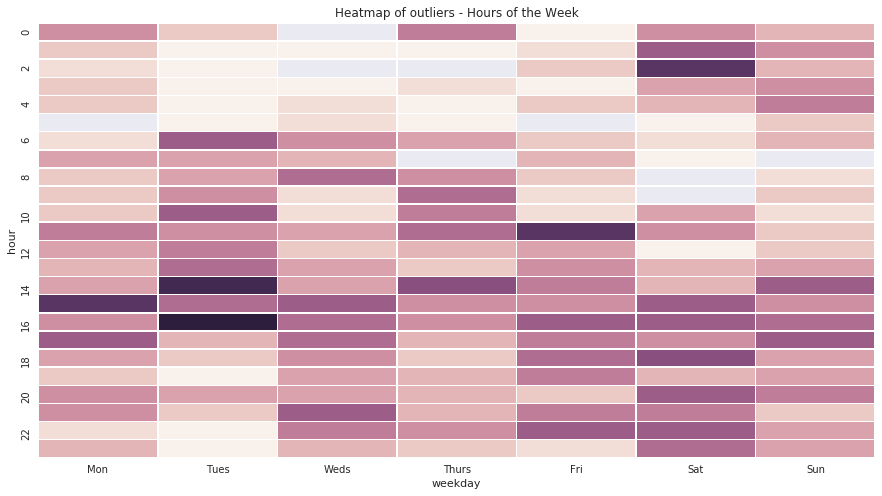

In [219]:
weekday = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(15,8))
pivot = df.pivot('hour','weekday', 'total_amount')
ax = sns.heatmap(pivot, xticklabels = weekday, yticklabels = 2, linewidths=.5, cbar = False)
ax.set_title('Heatmap of outliers - Hours of the Week')


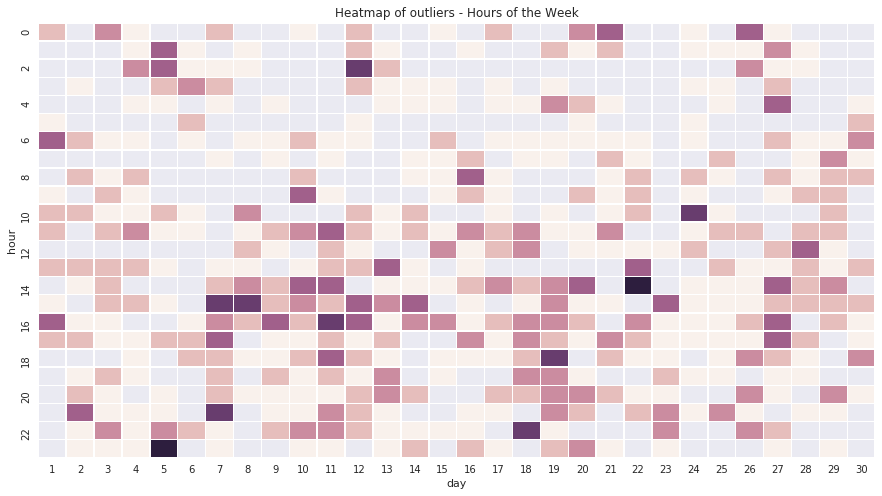

In [221]:
dfday = df_anomalies.groupby(['day', 'hour'])['total_amount'].count().reset_index()
plt.figure(figsize=(15,8))
pivot = dfday.pivot('hour','day', 'total_amount')
ax = sns.heatmap(pivot, yticklabels = 2, linewidths=.5, cbar = False)
ax.set_title('Heatmap of outliers - Hours of the Week')


Sadly evaluating the time data for the anomalies yield no consistent clue to when these occur. All I can tell is that most of these trips aren't coming to or from the airport, so some people are just hopping into very trips just randomly.  

In [231]:
df_anomalies[df_anomalies['rate'] < 1].describe()

,trip_distance,fare_amount,tip_amount,total_amount,trip_length,weekday,day,hour,rate,tip_percent,airport,labels
count,52.000000,52.000000,52.0,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.0,52.000000,52.000000
mean,11.562115,63.689231,0.0,66.760385,1409.649359,4.365385,17.096154,12.615385,0.494768,0.0,0.288462,0.980769
std,7.134460,59.901135,0.0,59.955233,47.316121,2.133108,8.049503,7.708294,0.305800,0.0,0.775521,0.577024
min,0.000000,41.000000,0.0,42.800000,1183.150000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,6.190000,45.875000,0.0,49.630000,1409.754167,2.000000,11.000000,4.000000,0.273305,0.0,0.000000,1.000000
50%,14.325000,52.000000,0.0,52.800000,1422.691667,5.000000,19.000000,14.000000,0.607776,0.0,0.000000,1.000000
75%,16.687500,61.750000,0.0,62.800000,1429.595833,6.000000,24.000000,19.000000,0.731005,0.0,0.000000,1.000000
max,22.590000,475.000000,0.0,475.000000,1439.533333,7.000000,29.000000,23.000000,0.955112,0.0,3.000000,2.000000


A small percent of the anomalies (6.9%) are due to broken meters since it's nearly impossible to go less than a mile per hour or take almost an entire day to go less than 22.6 miles  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ce1e792e8>]], dtype=object)

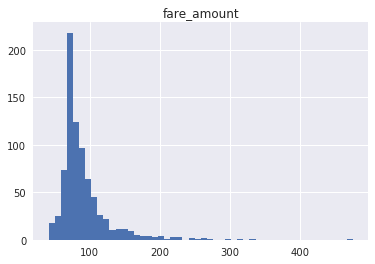

In [233]:
df_anomalies.hist('fare_amount', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ce1e0dfd0>]], dtype=object)

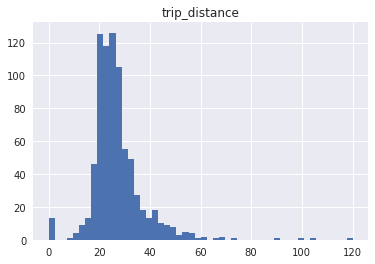

In [234]:
df_anomalies.hist('trip_distance', bins = 50)

In [244]:
df_anomalies.describe()

,trip_distance,fare_amount,tip_amount,total_amount,trip_length,weekday,day,hour,rate,tip_percent,airport,labels
count,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,27.135013,90.519228,0.016785,94.682076,185.661920,4.070886,15.520253,13.034177,21.503095,0.000211,0.348101,0.975949
std,10.784712,38.234822,0.471770,38.778149,354.203978,2.011384,8.412313,6.395903,11.609863,0.005930,0.883070,0.554442
min,0.000000,41.000000,0.000000,42.800000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.450000,70.000000,0.000000,72.800000,59.712500,2.000000,9.000000,9.000000,14.110156,0.000000,0.000000,1.000000
50%,25.200000,79.000000,0.000000,83.440000,76.166667,4.000000,15.500000,14.000000,20.719203,0.000000,0.000000,1.000000
75%,30.310000,98.000000,0.000000,103.497500,102.233333,6.000000,22.000000,18.000000,28.267191,0.000000,0.000000,1.000000
max,120.130000,475.000000,13.260000,475.000000,1439.583333,7.000000,30.000000,23.000000,60.046089,0.166667,3.000000,2.000000


In [246]:
df_anomalies[df_anomalies['trip_length'] > 10.38]

,trip_distance,fare_amount,tip_amount,total_amount,trip_length,weekday,day,hour,rate,tip_percent,airport,labels
528,22.85,65.5,0.0,66.80,62.750000,2,1,0,21.848606,0.0,0,1
608,33.60,87.5,0.0,88.80,40.933333,2,1,0,49.250814,0.0,0,1
2176,47.60,125.0,0.0,125.00,62.700000,2,1,5,45.550239,0.0,0,1
2444,25.86,85.5,0.0,103.30,31.316667,2,1,6,49.545503,0.0,3,1
2479,18.69,88.5,0.0,89.30,78.950000,2,1,6,14.203927,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
769511,22.87,66.5,0.0,68.30,69.950000,3,30,17,19.616869,0.0,2,1
770288,27.48,73.0,0.0,74.80,44.650000,3,30,18,36.927212,0.0,2,1
770820,19.38,66.0,0.0,73.34,65.066667,3,30,18,17.870902,0.0,0,1
770892,17.43,200.0,0.0,200.00,152.450000,3,30,18,6.859954,0.0,0,1


Ahh my anomaly detector is highlighting data that's well beyond the average trip duration; 99% of the data is above the median trip_length (10.38) and the average anomaly duration is 76.166667. You can see below that it captures the long tail of the trip_length distribution. Since total fare is related to the time one spends in the cab - I also capture the biggest cash spenders too in the anomaly detector.  

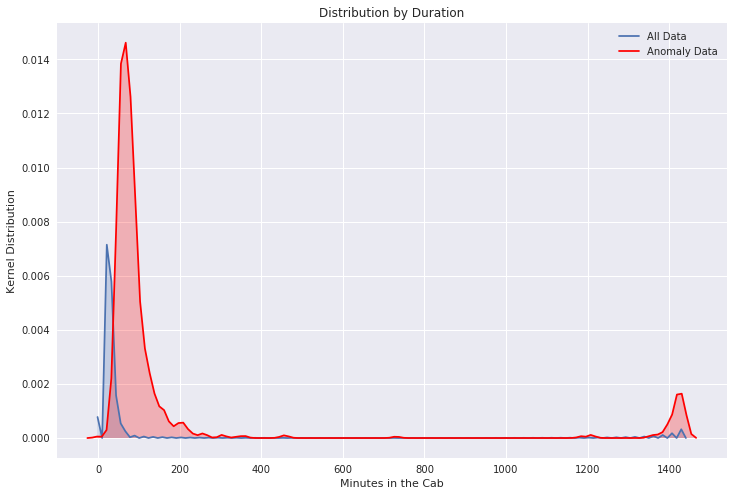

In [264]:
plt.figure(figsize = (12,8))
sns.kdeplot(df_features['trip_length'], label = 'All Data', shade=True)
sns.kdeplot(df_anomalies['trip_length'], label = 'Anomaly Data', shade=True, color = 'red')
plt.xlabel('Minutes in the Cab')
plt.ylabel('Kernel Distribution')
plt.title('Distribution by Duration')
plt.legend()

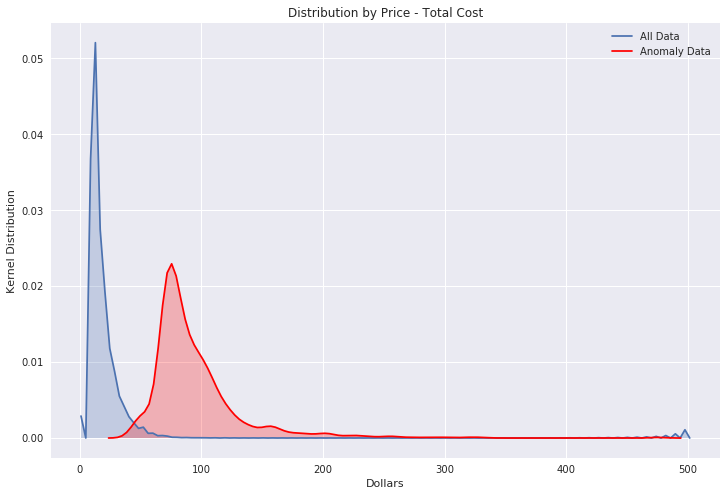

In [266]:
plt.figure(figsize = (12,8))
sns.kdeplot(df_features['total_amount'], label = 'All Data', shade=True)
sns.kdeplot(df_anomalies['total_amount'], label = 'Anomaly Data', shade=True, color = 'red')
plt.xlabel('Dollars')
plt.ylabel('Kernel Distribution')
plt.title('Distribution by Price - Total Cost')
plt.legend()

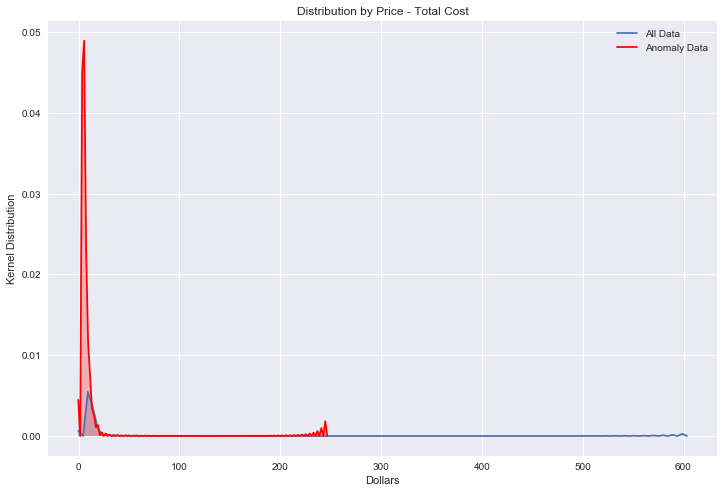

In [205]:
plt.figure(figsize = (12,8))
sns.kdeplot(df_features['trip_distance'], label = 'All Data', shade=True)
sns.kdeplot(df_anomalies['trip_distance'], label = 'Anomaly Data', shade=True, color = 'red')
plt.xlabel('Dollars')
plt.ylabel('Kernel Distribution')
plt.title('Distribution by Price - Total Cost')
plt.legend()